# STAT8107 Data Mining Techniques
## Group Project

# Import modules and configuration

In [78]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from scipy.stats import zscore
from typing import List
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

%matplotlib inline

# Functions

In [79]:
def plt_add_labels(x: List[str],
                   y: List[int]) -> None:
    y_scale = y.mean()/100
    for i in range(len(x)):
        plt.text(i, y[i]+y_scale, y[i], ha = 'center')

def print_missing_val_count(df: pd.DataFrame) -> None:
    # Missing value counts
    df_na_cnt = df.isnull().sum()
    df_record_cnt = df.shape[0]
    
    # Print the count of missing value for each feature
    if df_na_cnt.sum() > 0:
        print("The following columns have missing values:")
        for col, na_cnt in zip(df_na_cnt.index, df_na_cnt.values):
            if na_cnt > 0:
                print(f"{col} has {na_cnt} ({100*na_cnt/df_record_cnt:0.1f}%) missing value.")
    else:
        print("The dataframe does not have missing values.")

def knn_imputation(df: pd.DataFrame,
                   feature_columns: List[str],
                   target_column: str) -> None:
    """
    :param df: Dataframe for missing value imputation
    :param feature_columns: list of feature names (string) for knn imputation
    :param target_column: feature name (string) to be imputed
    :return Nothing
    """
    # Fit KNN model with records have non-null value in target column
    df_clean = df[~df[target_column].isna()]
    knn = KNeighborsRegressor(p=1, n_neighbors=3)
    knn.fit(df_clean[feature_columns], df_clean[target_column])
    # Predict the missing values
    df_miss = df[df[target_column].isna()]
    if df_miss.shape[0] > 0:
        y_pred = knn.predict(df_miss[feature_columns])
        # Impute the missing values
        df.loc[df[target_column].isna(), target_column] = y_pred
        print(f"Missing values in {target_column} has been imputed.")
    else:
        print(f"There is no missing values in {target_column}. No action.")

def one_hot_encoding(df: pd.DataFrame,
                     column:str) -> pd.DataFrame:
    distinct_values = set(df[column])
    
    for value in distinct_values:
        new_column = column + "_" + value
        df[new_column] = df[column].apply(lambda x: 1 if x == value else 0)
    
    df = df.drop(column, axis=1)
    
    return df

def regression_report(y_test: List[float],
                      y_pred: List[float],
                      p: int) -> str:
    n = y_test.shape[0]
    
    root_mse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
    
    metrics = f"\
Rooted-MSE: {root_mse:.4}\n\
MAE: {mae:.4}\n\
Adjusted R-Squared: {adj_r2:.4f}"
    
    return metrics

def predict_with_regressor(regressor: "sklearn.regressor",
                           X_train: pd.DataFrame,
                           X_test: pd.DataFrame,
                           y_train: List[float],
                           y_test: List[float]) -> None:
    y_pred = regressor.fit(X_train, y_train).predict(X_test)
    
    print("---------- " + regressor.__class__.__name__ + " ----------")
    print(regression_report(y_test, y_pred, X_train.shape[1]))
    print("")

def predict_with_regressors(regressors, X_train, X_test, y_train, y_test) -> None:
    for regressor in regressors(0):
        predict_with_regressor(regressor, X_train, X_test, y_train, y_test)

# Load Data

In [80]:
# Read csv files
price_train_df = pd.read_csv('trainPrice.csv')
price_test_df = pd.read_csv('testPrice.csv')
school_df = pd.read_csv('Schools.csv')
subway_df = pd.read_csv('Subways.csv')
submission_price_df = pd.read_csv('submissionPrice.csv')

## 2.2 Input Files and Their Basic Information

In [81]:
price_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1601458 entries, 0 to 1601457
Data columns (total 25 columns):
 #   Column                              Non-Null Count    Dtype  
---  ------                              --------------    -----  
 0   key                                 1601458 non-null  int64  
 1   apartment_id                        1601458 non-null  int64  
 2   city                                1601458 non-null  int64  
 3   transaction_year_month              1601458 non-null  int64  
 4   transaction_date                    1601458 non-null  object 
 5   year_of_completion                  1601458 non-null  int64  
 6   exclusive_use_area                  1601458 non-null  float64
 7   floor                               1601458 non-null  int64  
 8   latitude                            1601458 non-null  float64
 9   longitude                           1601458 non-null  float64
 10  address_by_law                      1601458 non-null  int64  
 11  total_parki

In [82]:
price_train_df.head(10)

key  apartment_id  city  transaction_year_month transaction_date  \
0    0          5584     1                  200601            11~20   
1    1          5584     1                  200601            11~20   
2    2          5059     1                  200601            11~20   
3    3          2816     1                  200601            11~20   
4    4          2816     1                  200601            11~20   
5    5          2815     1                  200601            11~20   
6    6          2815     1                  200601            11~20   
7    7          9867     1                  200601            11~20   
8    8          2818     1                  200601            11~20   
9    9          2817     1                  200601            11~20   

   year_of_completion  exclusive_use_area  floor   latitude   longitude  \
0                1999               47.43      6  37.585965  127.000231   
1                1999               44.37      8  37.585965  127.000231   
2                1992               54.70      8  37.580511  127.014016   
3                1993               64.66     11  37.580324  127.011788   
4                1993              106.62      7  37.580324  127.011788   
5                2000               84.92      9  37.575381  126.960804   
6                2000               60.00     13  37.575381  126.960804   
7                2005               84.76     10  37.559200  127.019503   
8                1999               84.88     18  37.555060  127.014495   
9                2002               59.94     12  37.549828  127.009284   

   address_by_law  total_parking_capacity_in_site  \
0      1111017100                           163.0   
1      1111017100                           163.0   
2      1111017400                           902.0   
3      1111017400                           902.0   
4      1111017400                           902.0   
5      1111018700                          1365.0   
6      1111018700                          1365.0   
7      1114016200                           652.0   
8      1114016200                          2091.0   
9      1114016200                          4329.0   

   total_household_count_in_sites  apartment_building_count_in_sites  \
0                             136                                  1   
1                             136                                  1   
2                             585                                  5   
3                             919                                  7   
4                             919                                  7   
5                             964                                 12   
6                             964                                 12   
7                             461                                  9   
8                            2282                                 19   
9                            5150                                 42   

   tallest_building_in_sites  lowest_building_in_sites   heat_type heat_fuel  \
0                        8.0                       4.0  individual       gas   
1                        8.0                       4.0  individual       gas   
2                       14.0                       9.0  individual       gas   
3                       15.0                      11.0  individual       gas   
4                       15.0                      11.0  individual       gas   
5                       23.0                      10.0  individual       gas   
6                       23.0                      10.0  individual       gas   
7                       23.0                       6.0  individual       gas   
8                       20.0                       8.0  individual       gas   
9                       18.0                      11.0  individual       gas   

   room_id  supply_area  total_household_count_of_area_type  room_count  \
0    91120        65.63                                  46   

In [83]:
price_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3918 entries, 0 to 3917
Data columns (total 25 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   key                                 3918 non-null   int64  
 1   apartment_id                        3918 non-null   int64  
 2   city                                3918 non-null   int64  
 3   transaction_year_month              3918 non-null   int64  
 4   transaction_date                    3918 non-null   object 
 5   year_of_completion                  3918 non-null   int64  
 6   exclusive_use_area                  3918 non-null   float64
 7   floor                               3918 non-null   int64  
 8   latitude                            3918 non-null   float64
 9   longitude                           3918 non-null   float64
 10  address_by_law                      3918 non-null   int64  
 11  total_parking_capacity_in_site      3547 no

In [84]:
price_test_df.head(10)

key  apartment_id  city  transaction_year_month transaction_date  \
0   462533          3751     1                  200912            21~31   
1   764018         14029     1                  201304             1~10   
2   813528         12304     1                  201309            21~30   
3   845097         22241     1                  201312             1~10   
4   856338           316     1                  201401             1~10   
5   977181         14140     1                  201411             1~10   
6  1037012         18263     1                  201503             1~10   
7  1158117          1299     1                  201510            21~31   
8  1204038         34895     1                  201603             1~10   
9  1204146           710     1                  201603             1~10   

   year_of_completion  exclusive_use_area  floor   latitude   longitude  \
0                1984              83.580     14  37.519926  127.052515   
1                1968             107.170     10  37.572215  126.987643   
2                1968              36.170      6  37.570067  127.010640   
3                2007              45.670      8  37.556938  126.859255   
4                1988              41.850      4  37.652256  127.082003   
5                1972             124.500      7  37.544317  127.001489   
6                2008              84.468      1  37.645004  127.067781   
7                1983             143.950      1  37.510144  127.011731   
8                2010              84.780     24  37.573799  126.890999   
9                1989              59.220      8  37.633702  127.067866   

   address_by_law  total_parking_capacity_in_site  \
0      1168010400                           375.0   
1      1111013700                             NaN   
2      1111017400                             NaN   
3      1150010200                           216.0   
4      1135010600                             NaN   
5      1117013100                             NaN   
6      1135010600                           146.0   
7      1165010600                             NaN   
8      1144012700                           318.0   
9      1135010400                           540.0   

   total_household_count_in_sites  apartment_building_count_in_sites  \
0                             375                                  4   
1                             149                                  1   
2                             120                                  4   
3                             419                                  1   
4                             210                                  2   
5                             122                                  1   
6                             219                                  4   
7                             112                                  1   
8                             240                                  2   
9                            1880                                 15   

   tallest_building_in_sites  lowest_building_in_sites   heat_type  \
0                       15.0                      15.0    district   
1                       15.0                       8.0  individual   
2                        5.0                       4.0  individual   
3                       15.0                      15.0  individual   
4                        5.0                       5.0  individual   
5                       16.0                      16.0     central   
6                       10.0                      10.0  individual   
7                       14.0                      14.0    district   
8                       33.0                      30.0    district   
9                       15.0                       6.0     central   

      heat_fuel  room_id  supply_area  total_household_count_of_area_type  \
0  cogeneration     6648       107.19                                   2   
1           gas    46184       107.17                

In [85]:
# Rename Training Set to Price Data Set
price_df = price_train_df.copy()

In [86]:
school_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1921 entries, 0 to 1920
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   school_code      1921 non-null   object 
 1   latitude         1921 non-null   float64
 2   longitude        1921 non-null   float64
 3   school_class     1921 non-null   object 
 4   operation_type   1921 non-null   object 
 5   highschool_type  462 non-null    object 
 6   gender           1921 non-null   object 
 7   foundation_date  1921 non-null   object 
 8   address_by_law   1921 non-null   int64  
dtypes: float64(2), int64(1), object(6)
memory usage: 135.2+ KB


In [87]:
school_df.head(10)

school_code   latitude   longitude school_class operation_type  \
0  S000003511  37.490880  127.015082   elementary       national   
1  S000003563  37.577782  127.002915   elementary       national   
2  S010000737  37.481366  127.059055   elementary         public   
3  S010000738  37.485744  127.058002   elementary         public   
4  S010000741  37.480805  127.051891   elementary         public   
5  S010000742  37.508423  127.026187   elementary         public   
6  S010000743  37.494398  127.065164   elementary         public   
7  S010000744  37.492601  127.053554   elementary         public   
8  S010000745  37.481135  127.086301   elementary         public   
9  S010000746  37.464246  127.105618   elementary         public   

  highschool_type gender foundation_date  address_by_law  
0             NaN   both       1953.1.31      1165010800  
1             NaN   both       1946.8.22      1111016800  
2             NaN   both       1982.9.20      1168010300  
3             NaN   both      1987.11.17      1168010300  
4             NaN   both      1983.11.30      1168010300  
5             NaN   both      1972.11.23      1168010800  
6             NaN   both        1981.9.9      1168010600  
7             NaN   both       1979.3.27      1168011800  
8             NaN   both        1994.8.5      1168011400  
9             NaN   both      1932.11.25      1168011100

In [88]:
subway_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405 entries, 0 to 404
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   station_id      405 non-null    int64  
 1   latitude        405 non-null    float64
 2   longitude       405 non-null    float64
 3   subway_line     405 non-null    object 
 4   address_by_law  396 non-null    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 15.9+ KB


In [89]:
subway_df.head(10)

station_id   latitude   longitude subway_line  address_by_law
0           1  37.555729  126.972145   1,4,KJ,AP    1.114012e+09
1           2  37.565624  126.976936         1,2    1.114017e+09
2           3  37.570169  126.983099           1    1.111013e+09
3           4  37.571570  126.991895       1,3,5    1.111016e+09
4           5  37.570988  127.001921           1    1.111016e+09
5           6  37.571256  127.009080         1,4             NaN
6           7  37.576107  127.024536      1,2,US    1.123010e+09
7           8  37.578196  127.034867           1    1.123010e+09
8           9  37.580166  127.044327     1,KJ,KC    1.123011e+09
9          10  37.573246  127.016365         1,6    1.111018e+09

In [90]:
submission_price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3918 entries, 0 to 3917
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   key                     3918 non-null   int64
 1   transaction_real_price  3918 non-null   int64
dtypes: int64(2)
memory usage: 61.3 KB


# 2.3 Exploratory Data Analysis (EDA)

## 2.3.1 Price Data Set (trainPrice.csv)

## 2.3.1.1 Univariate Analysis

## Field - city

In [15]:
# Distinct values
price_df["city"].drop_duplicates().sort_values().to_list() # There are only 2 distinct values

[0, 1]

In [16]:
# Sample few (latitude, longitude) pairs from records with city = 0
price_df[price_df["city"] == 0][["latitude", "longitude"]].head(3)

latitude   longitude
1491  35.117560  129.011018
1492  35.118632  129.010886
1493  35.081732  129.019474

In [17]:
# Sample few (latitude, longitude) pairs from records with city = 1
price_df[price_df["city"] == 1][["latitude", "longitude"]].head(3)

latitude   longitude
0  37.585965  127.000231
1  37.585965  127.000231
2  37.580511  127.014016

## Field - transaction_date

In [18]:
print("Distinct values in column transaction_date are", str(sorted(set(price_df['transaction_date'])))[1:-1])

Distinct values in column transaction_date are '11~20', '1~10', '21~28', '21~29', '21~30', '21~31'


## Field - transaction_real_price

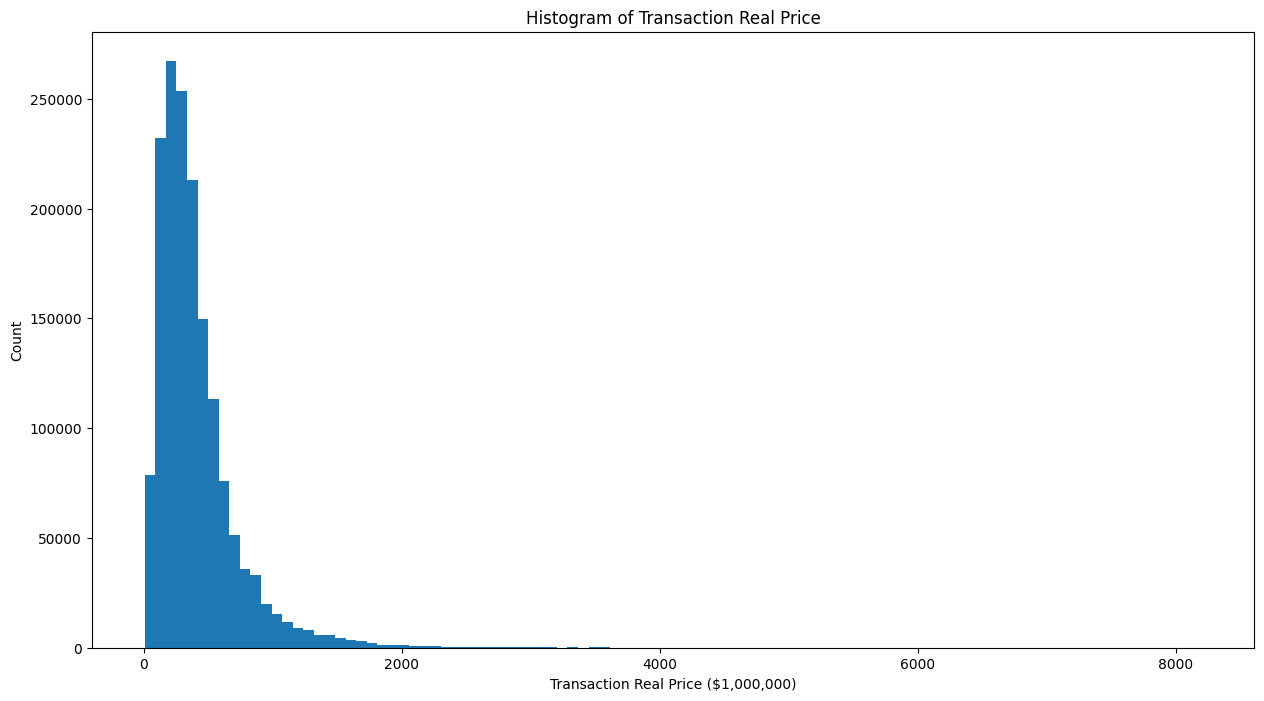

In [19]:
# Histogram of Transaction Real Price
fig, ax = plt.subplots(figsize=(15, 8))
plt.hist(price_df["transaction_real_price"]/1000000, bins=100)
plt.title('Histogram of Transaction Real Price')
plt.xlabel('Transaction Real Price ($1,000,000)')
plt.ylabel('Count')
plt.show()

In [20]:
print(f"Maximum transaction price is ${int(price_df['transaction_real_price'].max()/1000000)} M")

Maximum transaction price is $8200 M


## Field - transaction_year_month

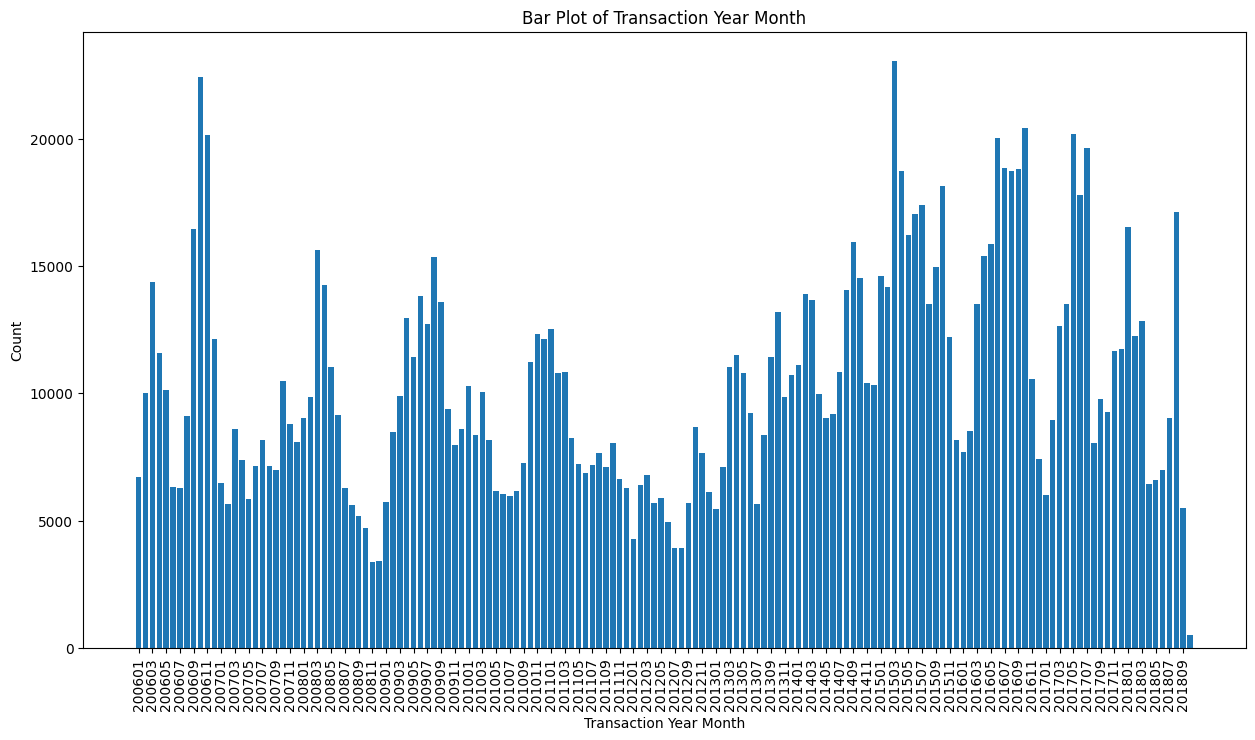

The mean of transaction count per month is 10399.08.


In [21]:
# Bar plot of Transaction Year Month
# Drop missing values (NA) and calculate the counts of each value
val_count = price_df["transaction_year_month"].dropna().astype("str").value_counts()
val_count = val_count.sort_index()

val_mean = val_count.mean()

# Draw bar plot
fig, ax = plt.subplots(figsize=(15, 8))
plt.bar(val_count.index, val_count.values)
plt.title('Bar Plot of Transaction Year Month')
plt.xlabel('Transaction Year Month')
plt.ylabel('Count')
plt.xticks(range(len(val_count.index))[::2], val_count.index[::2], rotation=90)
plt.show()

print(f"The mean of transaction count per month is {val_mean:.2f}.")

## Fields - total_parking_capacity_in_site, total_household_count_in_sites, room_count and bathroom_count

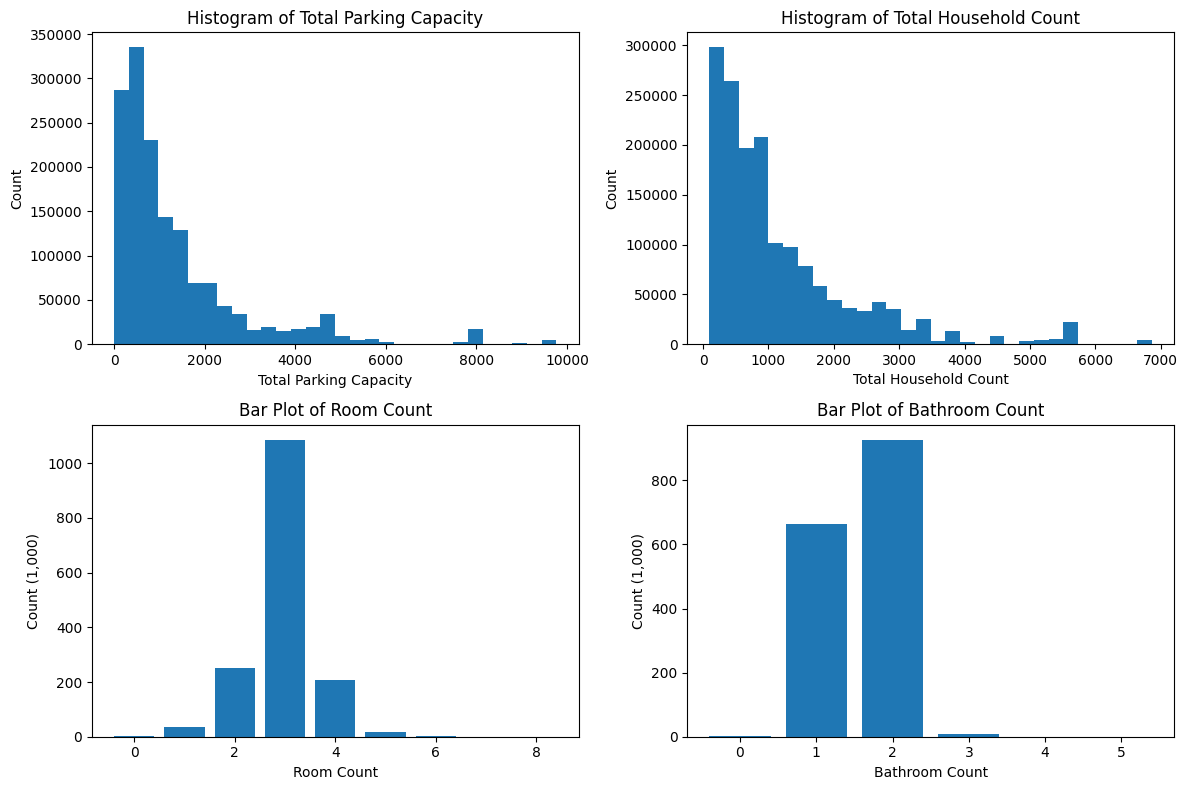

In [22]:
# Create a figure and add the axes for subgraphs
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Histogram of Total Parking Capacity
axes[0,0].hist(price_df["total_parking_capacity_in_site"], bins=30)
axes[0,0].set(title='Histogram of Total Parking Capacity')
axes[0,0].set_xlabel('Total Parking Capacity')
axes[0,0].set_ylabel('Count')

# Histogram of Total Household Count
axes[0,1].hist(price_df["total_household_count_in_sites"], bins=30)
axes[0,1].set(title='Histogram of Total Household Count')
axes[0,1].set_xlabel('Total Household Count')
axes[0,1].set_ylabel('Count')

# # Bar plot of Room Count
val_count = price_df["room_count"].dropna().value_counts() / 1000
val_count = val_count.sort_index()
axes[1,0].bar(val_count.index, val_count.values)
axes[1,0].set(title='Bar Plot of Room Count')
axes[1,0].set_xlabel('Room Count')
axes[1,0].set_ylabel('Count (1,000)')

# # Bar plot of Bathroom Count
val_count = price_df["bathroom_count"].dropna().value_counts() / 1000
val_count = val_count.sort_index()
axes[1,1].bar(val_count.index, val_count.values)
axes[1,1].set(title='Bar Plot of Bathroom Count')
axes[1,1].set_xlabel('Bathroom Count')
axes[1,1].set_ylabel('Count (1,000)')

plt.tight_layout()
plt.show()

In [23]:
print(f"Precentage of records have 2-4 rooms: \
{100 * price_df[price_df['room_count'].isin([2,3,4])].shape[0] / price_df.shape[0]:.0f}%")
print(f"Precentage of ecords have 1 or 2 bathrooms: \
{100 * price_df[price_df['bathroom_count'].isin([1,2])].shape[0] / price_df.shape[0]:.0f}%")

Precentage of records have 2-4 rooms: 96%
Precentage of ecords have 1 or 2 bathrooms: 99%


In [24]:
print(f"The mean of room_count and bathroom_count are \
{price_df['room_count'].mean():.2f} and {price_df['bathroom_count'].mean():.2f} respectively.")
print(f"The mode of room_count and bathroom_count are \
{price_df['room_count'].mode()[0]:.0f} and {price_df['bathroom_count'].mode()[0]:.0f} respectively.")

The mean of room_count and bathroom_count are 2.95 and 1.59 respectively.
The mode of room_count and bathroom_count are 3 and 2 respectively.


## 2.3.1.2 Multivariate Analysis

## Fields - transaction_year_month and transaction_real_price

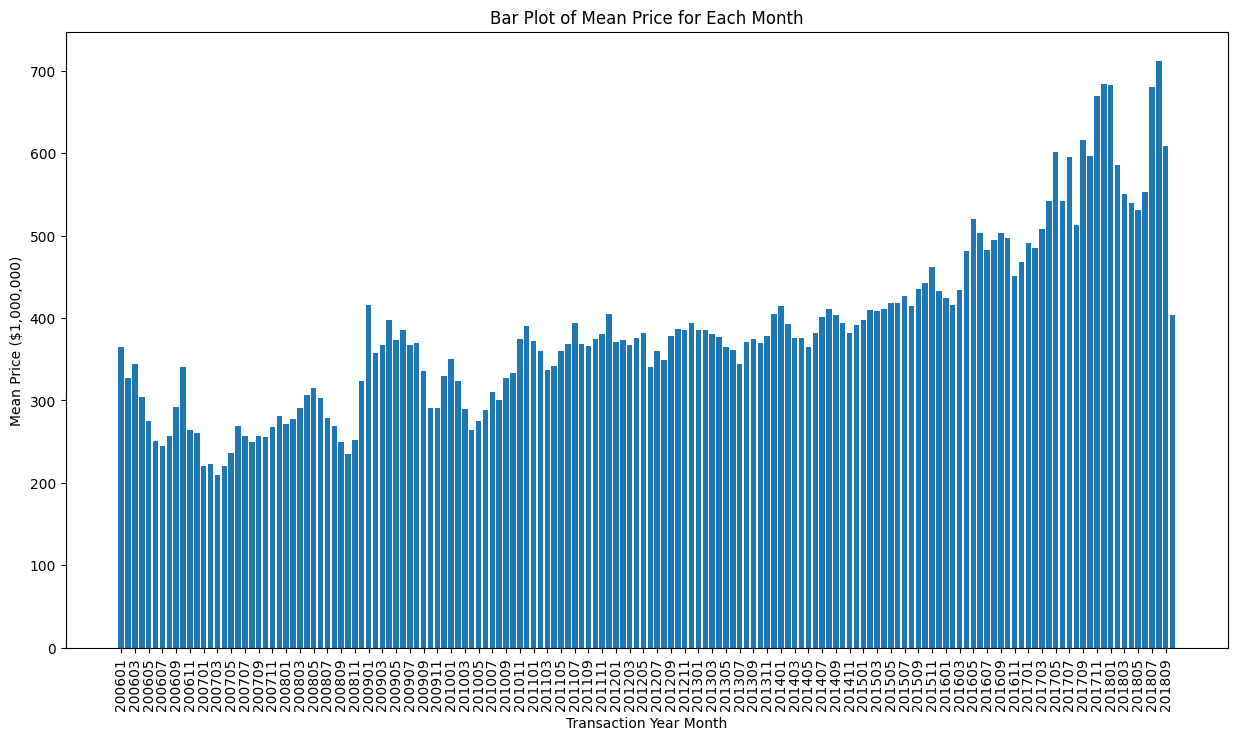

In [25]:
# Draw bar plot
price_mth_mean = price_df.groupby(['transaction_year_month'])['transaction_real_price'].mean().reset_index()
price_year_mth = price_mth_mean['transaction_year_month'].astype("str")
price_mean = price_mth_mean['transaction_real_price'] / 1000000


fig, ax = plt.subplots(figsize=(15, 8))
plt.bar(price_year_mth, price_mean)
plt.title('Bar Plot of Mean Price for Each Month')
plt.xlabel('Transaction Year Month')
plt.ylabel('Mean Price ($1,000,000)')
plt.xticks(range(len(price_year_mth))[::2], price_year_mth[::2], rotation=90)
plt.show()

## Fields - room_count and transaction_real_price

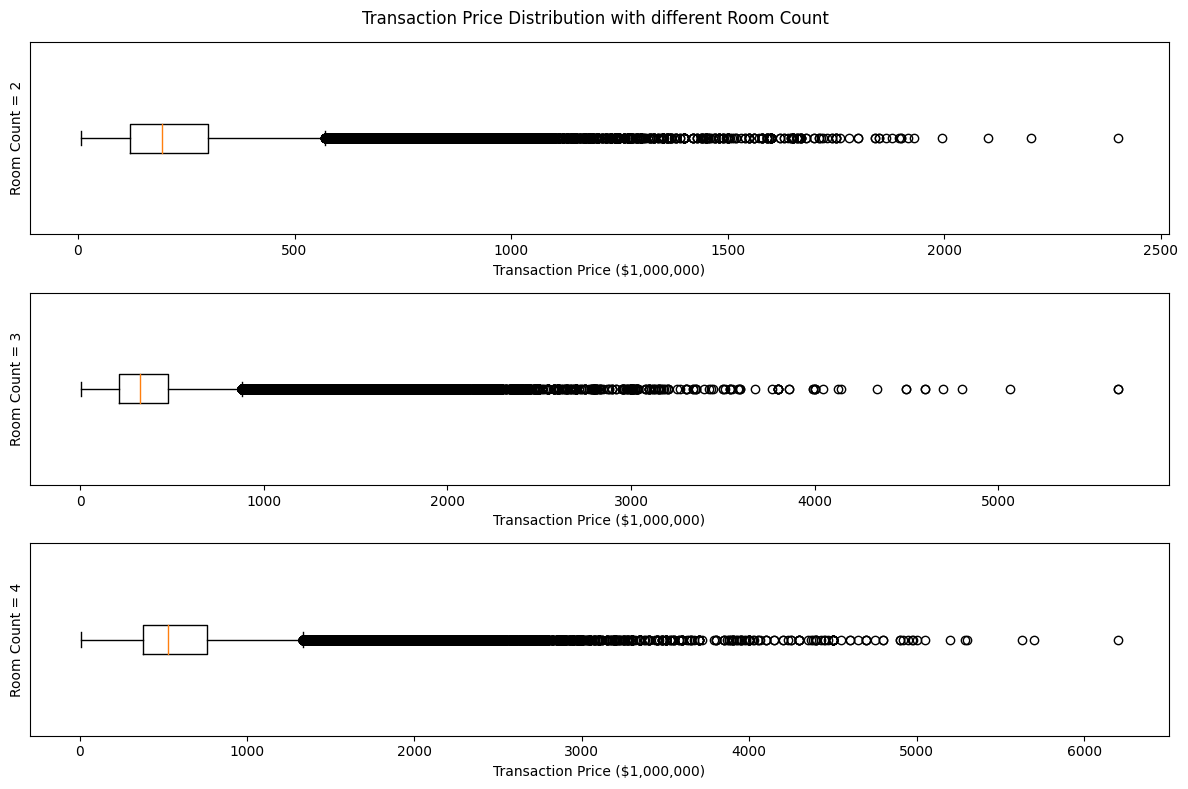

In [26]:
# Create a figure and add the axes for subgraphs
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 8))

for i in [2,3,4]:
    room_cnt_price = price_df[price_df['room_count'] == i]["transaction_real_price"] / 1000000

    axes[i-2].boxplot(room_cnt_price, vert=False) # showfliers=False
    axes[i-2].set_xlabel('Transaction Price ($1,000,000)')
    axes[i-2].set_ylabel(f'Room Count = {i}')
    axes[i-2].set_yticks([])

fig.suptitle('Transaction Price Distribution with different Room Count')
plt.tight_layout()
plt.show()

## Fields - bathroom_count and transaction_real_price

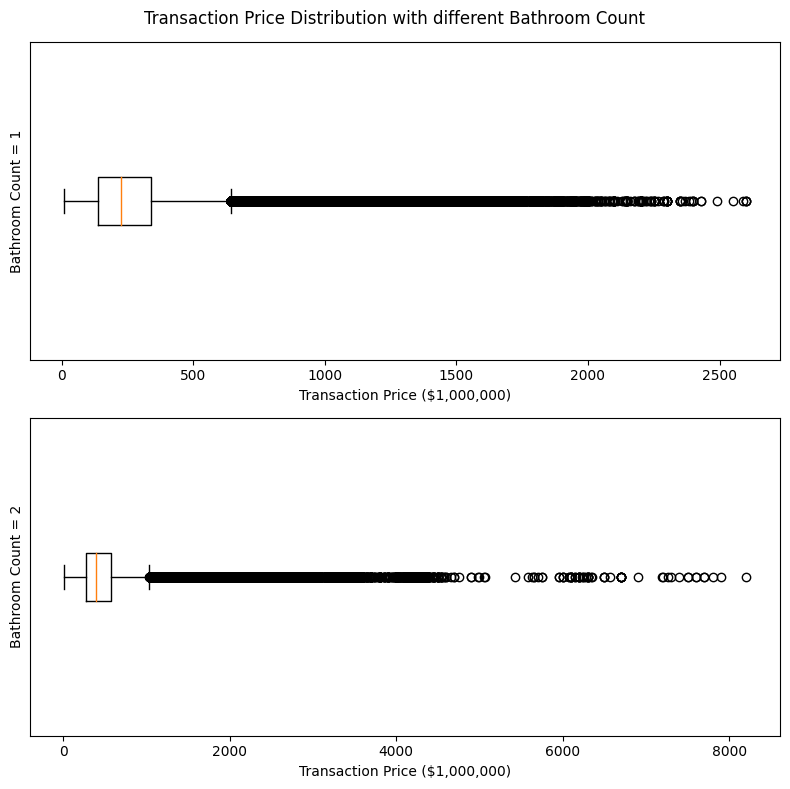

In [27]:
# Create a figure and add the axes for subgraphs
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

for i in [1,2]:
    room_cnt_price = price_df[price_df['bathroom_count'] == i]["transaction_real_price"] / 1000000

    axes[i-1].boxplot(room_cnt_price, vert=False) # showfliers=False
    axes[i-1].set_xlabel('Transaction Price ($1,000,000)')
    axes[i-1].set_ylabel(f'Bathroom Count = {i}')
    axes[i-1].set_yticks([])

fig.suptitle('Transaction Price Distribution with different Bathroom Count')
plt.tight_layout()
plt.show()

## Fields - city, latitude and longitude

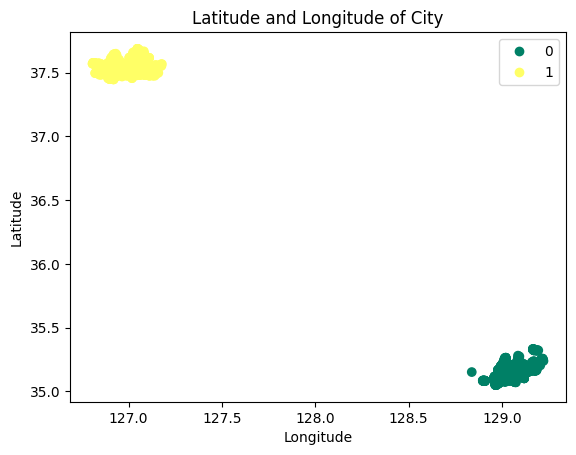

In [28]:
# Sample 1000 records from each class
price_sample = price_df.groupby('city').apply(lambda x: x.sample(1000))

# Scatter Plot of Latitude and Longitude with city labels
scatter = plt.scatter(price_sample['longitude'], price_sample['latitude'], c=price_sample['city'], cmap='summer')
plt.title('Latitude and Longitude of City')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(*scatter.legend_elements(), loc='upper right')
plt.show()

## Fields - All Numeric Fields

In [28]:
price_df.corr() \
    .style \
    .background_gradient(cmap='coolwarm') \
    .set_precision(2) \
    .set_table_styles([dict(selector="th.col_heading",props=[("writing-mode", "vertical-rl")])])

## 2.3.2 School Data Set (Schools.csv)

## 2.3.2.1 Univariate Analysis

## Field - school_class

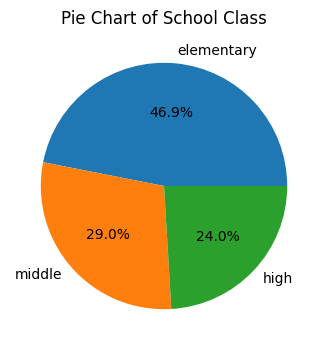

In [31]:
# Pie chart of School Class
# Drop missing values (NA) and calculate the counts of each value
val_count = school_df["school_class"].dropna().astype("str").value_counts()

# Draw pie chart
fig, ax = plt.subplots(figsize=(4, 4))
plt.title('Pie Chart of School Class')
plt.pie(val_count.values, labels = val_count.index, autopct='%1.1f%%')
plt.show() 

## Field - operation_type

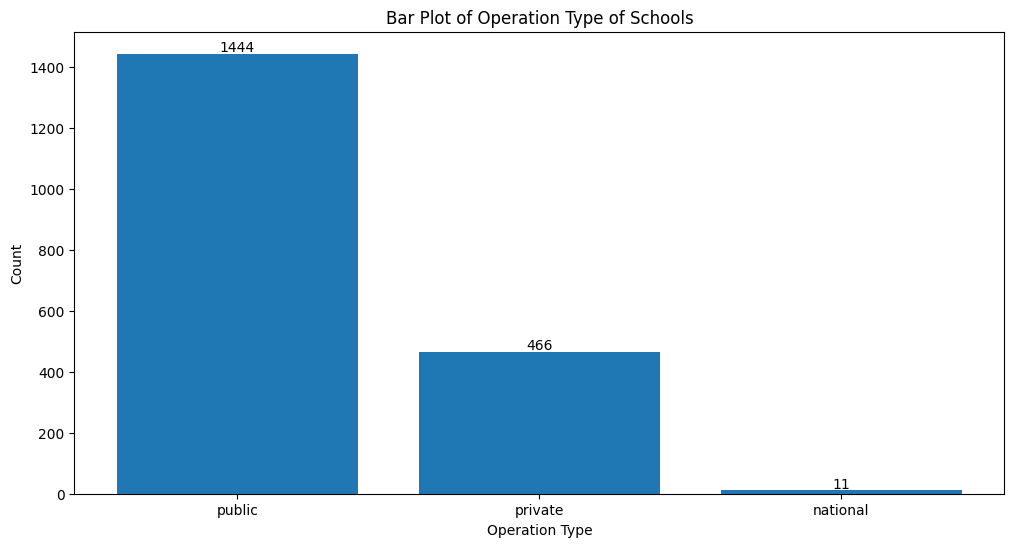

In [32]:
# Bar plot of Operation Type of Schools
# Drop missing values (NA) and calculate the counts of each value
val_count = school_df["operation_type"].dropna().astype("str").value_counts()

# Draw bar plot
fig, ax = plt.subplots(figsize=(12, 6))
plt.bar(val_count.index, val_count.values)
plt.title('Bar Plot of Operation Type of Schools')
plt.xlabel('Operation Type')
plt.ylabel('Count')
plt_add_labels(val_count.index, val_count.values)
plt.xticks(range(len(val_count.index)), val_count.index)
plt.show()

In [33]:
print(f"Precentage of public schools: {100 * school_df[school_df['operation_type'] == 'public'].shape[0] / school_df.shape[0]:.1f}%")

Precentage of public schools: 75.2%


## Field - highschool_type

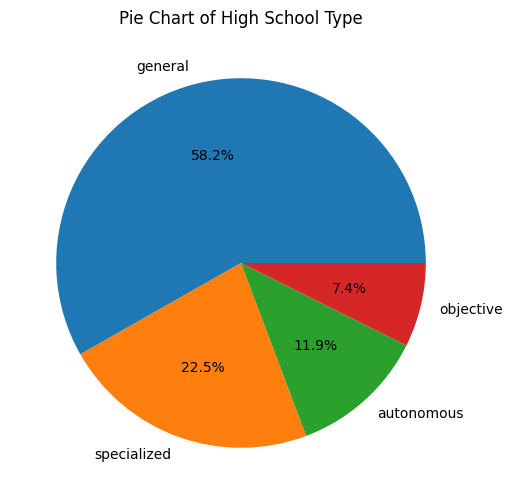

In [34]:
# Pie chart of High School Type
# Drop missing values (NA) and calculate the counts of each value
val_count = school_df["highschool_type"].dropna().astype("str").value_counts()

# Draw pie chart
fig, ax = plt.subplots(figsize=(12, 6))
plt.title('Pie Chart of High School Type')
plt.pie(val_count.values, labels = val_count.index, autopct='%1.1f%%')
plt.show() 

In [35]:
print(f"The school classes with NULL high school type: \
{str(list(school_df[school_df['highschool_type'].isna()]['school_class'].drop_duplicates()))[1:-1]}")

The school classes with NULL high school type: 'elementary', 'middle'


## Field - gender

In [36]:
school_df["gender"].dropna().astype("str").value_counts()

gender
both      1524
male       199
female     198
Name: count, dtype: int64

## 2.3.2.2 Multivariate Analysis

## Fields - school_class and gender

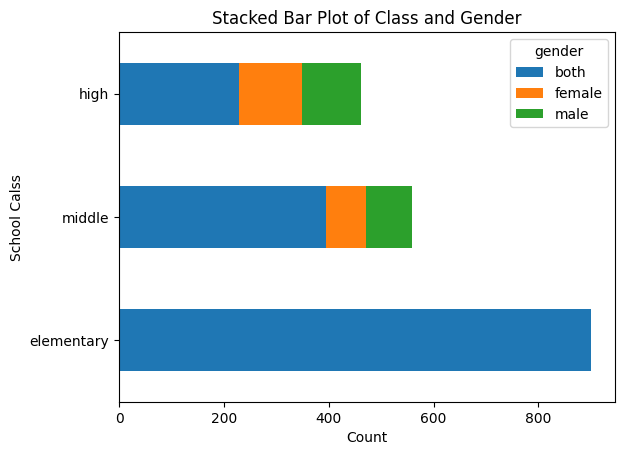

In [37]:
# Stack Bar Plot of School Class and Gender
class_gender_cnt = school_df.groupby(['school_class', 'gender']).size().reset_index(name='count')
class_gender_cnt = class_gender_cnt.pivot(index='school_class', columns='gender', values='count')
class_gender_cnt.reset_index(inplace=True)
class_gender_cnt['school_class'] = pd.Categorical(class_gender_cnt['school_class'], ["elementary", "middle", "high"])
class_gender_cnt = class_gender_cnt.sort_values("school_class")

class_gender_cnt.plot(
    x = 'school_class', 
    kind = 'barh', 
    stacked = True, 
    title = 'Stacked Bar Plot of Class and Gender', 
    mark_right = True) 

plt.xlabel('Count')
plt.ylabel('School Calss')
plt.show()

## Fields - school_class and operation_type

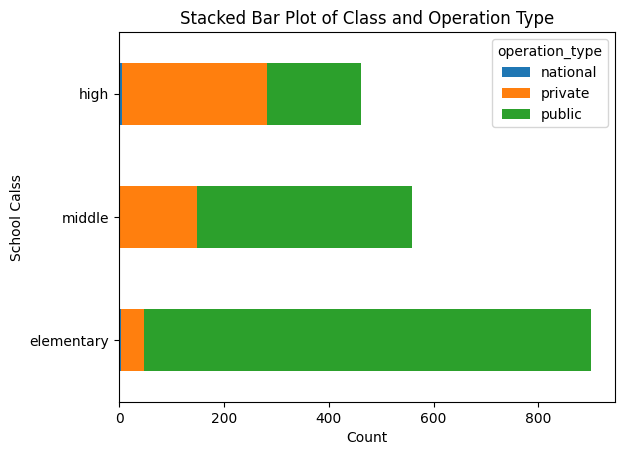

In [38]:
# Stack Bar Plot of School Class and Operation Type
class_opt_type_cnt = school_df.groupby(['school_class', 'operation_type']).size().reset_index(name='count')
class_opt_type_cnt = class_opt_type_cnt.pivot(index='school_class', columns='operation_type', values='count')
class_opt_type_cnt.reset_index(inplace=True)
class_opt_type_cnt['school_class'] = pd.Categorical(class_opt_type_cnt['school_class'], ["elementary", "middle", "high"])
class_opt_type_cnt = class_opt_type_cnt.sort_values("school_class")

class_opt_type_cnt.plot(
    x = 'school_class', 
    kind = 'barh', 
    stacked = True, 
    title = 'Stacked Bar Plot of Class and Operation Type', 
    mark_right = True) 

plt.xlabel('Count')
plt.ylabel('School Calss')
plt.show()

## 2.3.3 Subway Data Set (Subways.csv)

## 2.3.2.1 Univariate Analysis

## Field - subway_line

In [39]:
subway_line_list = []
for subway_line in subway_df["subway_line"].drop_duplicates().tolist():
    subway_line_list += subway_line.split(",")

subway_line_list = list(set(subway_line_list))
subway_line_list.sort()
print(f"There are {len(subway_line_list)} subway lines: {str(subway_line_list)[1:-1]}")

There are 21 subway lines: '1', '2', '3', '4', '5', '6', '7', '8', '9', 'AP', 'B1', 'B2', 'B3', 'B4', 'BD', 'BK', 'DL', 'KC', 'KJ', 'ND', 'US'


In [40]:
subway_line_split = subway_df[["station_id", "subway_line"]].copy()
subway_line_split['subway_line'] = subway_line_split['subway_line'].str.split(",")
subway_line_split = subway_line_split.explode('subway_line')
print("Number of stations for each line:")
print(subway_line_split["subway_line"].dropna().astype("str").value_counts())

Number of stations for each line:
subway_line
2     51
5     51
B1    40
7     39
6     38
B2    38
1     36
3     33
9     30
4     26
KJ    22
B3    17
B4    14
BD    14
DL    13
8     11
BK     9
KC     6
AP     5
ND     4
US     3
Name: count, dtype: int64


## 2.3.3.2 Multivariate Analysis

## Fields - latitude and longitude

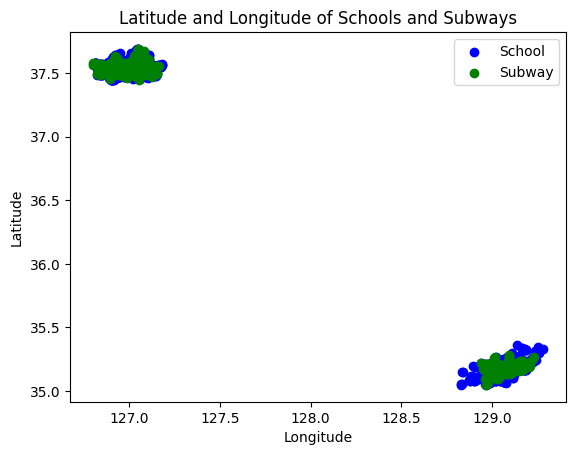

In [41]:
# Scatter Plot of Latitude and Longitude with city labels
plt.scatter(school_df['longitude'], school_df['latitude'], color='blue', label='School')
plt.scatter(subway_df['longitude'], subway_df['latitude'], color='green', label='Subway')
plt.title('Latitude and Longitude of Schools and Subways')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(loc='upper right')
plt.show()

# 3 Data Pre-processing

## 3.1 Missing Values Analysis

## 3.1.1 Price Data Set

In [42]:
print_missing_val_count(price_df)

The following columns have missing values:
total_parking_capacity_in_site has 91813 (5.7%) missing value.
tallest_building_in_sites has 9 (0.0%) missing value.
lowest_building_in_sites has 9 (0.0%) missing value.
heat_type has 2017 (0.1%) missing value.
heat_fuel has 9667 (0.6%) missing value.
room_count has 691 (0.0%) missing value.
bathroom_count has 691 (0.0%) missing value.
front_door_structure has 13892 (0.9%) missing value.


In [43]:
# NULL values in lowest_building_in_sites and tallest_building_in_sites
print("lowest_building_in_sites is NULL if and only if tallest_building_in_sites is NULL:", \
(price_df['lowest_building_in_sites'].isnull() == price_df['tallest_building_in_sites'].isnull()).all())

lowest_building_in_sites is NULL if and only if tallest_building_in_sites is NULL: True


In [44]:
# NULL values in room_count and bathroom_count
print("room_count is NULL if and only if bathroom_count is NULL:", \
(price_df['room_count'].isnull() == price_df['bathroom_count'].isnull()).all())

room_count is NULL if and only if bathroom_count is NULL: True


In [45]:
# NULL in heat_type =>  NULL in heat_fuel 
price_df[price_df['heat_type'].isna()]['heat_fuel'].drop_duplicates()

1012904    NaN
Name: heat_fuel, dtype: object

In [46]:
# Other form of missing value
price_df['front_door_structure'].value_counts()

front_door_structure
stairway    1146251
corridor     415209
mixed         26085
-                21
Name: count, dtype: int64

## 3.1.2 School Data Set

In [47]:
print_missing_val_count(school_df)

The following columns have missing values:
highschool_type has 1459 (76.0%) missing value.


In [48]:
school_df[school_df['highschool_type'].isna()]['school_class'].drop_duplicates()

0      elementary
200        middle
Name: school_class, dtype: object

## 3.1.3 Subway Data Set

In [49]:
print_missing_val_count(subway_df)

The following columns have missing values:
address_by_law has 9 (2.2%) missing value.


## 3.2 Imputation

## 3.2.1 Price Data Set 

In [50]:
# Standardized Dataframe
price_std = price_df.copy()

# Fill missing values with "-"
price_std[['heat_type', 'heat_fuel', 'front_door_structure']] = \
    price_std[['heat_type', 'heat_fuel', 'front_door_structure']].fillna('-')

# Fill missing values with 0
price_std[['room_count', 'bathroom_count', 'total_parking_capacity_in_site']] = \
    price_std[[ 'room_count', 'bathroom_count', 'total_parking_capacity_in_site']].fillna(0)

# Impute missing values using KNN
knn_imputation(price_std, ['longitude', 'latitude'], 'tallest_building_in_sites')

knn_imputation(price_std, ['longitude', 'latitude', 'tallest_building_in_sites'], 'lowest_building_in_sites')

Missing values in tallest_building_in_sites has been imputed.
Missing values in lowest_building_in_sites has been imputed.


In [51]:
# To ensure all missing values have been handled
print_missing_val_count(price_std)

The dataframe does not have missing values.


## 3.2.2 School Data Set

In [52]:
# Standardized Dataframe
school_df_std = school_df.copy()

# Fill missing values with "-"
school_df_std[['highschool_type']] = school_df_std[['highschool_type']].fillna('-')

In [53]:
# To ensure all missing values have been handled
print_missing_val_count(school_df_std)

The dataframe does not have missing values.


## 3.2.3 Subway Data Set

In [54]:
# Standardized Dataframe
subway_df_std = subway_df.copy()

# Fill missing values with "-"
subway_df_std[['address_by_law']] = subway_df_std[['address_by_law']].fillna('-')

In [55]:
# To ensure all missing values have been handled
print_missing_val_count(subway_df_std)

The dataframe does not have missing values.


## 3.3 Feature Creation 

## 3.3.1 Price Data Set 

In [56]:
# Break down transaction_month_year into two columns
price_std['transaction_year'] = price_std['transaction_year_month'].astype(str).str[:4].astype(int)
price_std['transaction_month'] = price_std['transaction_year_month'].astype(str).str[4:].astype(int)

# Obtain age of the building at the time of transaction
price_std['building_age'] = price_std['transaction_year'] - price_std['year_of_completion']

# Obtain height different between highest and lowest buildings
price_std['diff_height_in_site'] = price_std['tallest_building_in_sites'] - price_std['lowest_building_in_sites']

# Obtain ratio of exclusive use area to supply area
price_std['excl_use_area_ratio'] = price_std['exclusive_use_area'] / price_std['supply_area']

In [57]:
# Remove duplicated or non-informative columns
price_std = price_std.drop(['key', 'transaction_year_month', 'year_of_completion'], axis=1)

## 3.3.2 School Data Set

In [58]:
# Obtain foundation_year from foundation_date
school_df_std['foundation_year'] = school_df_std['foundation_date'].str[:4].astype(int)

In [59]:
# Range of longitude for city 0 and city 1
for i in [0, 1]:
    longitude_list = price_std[price_std['city'] == i]['longitude'].to_list()
    print(f"The range of longitude of city {i} is [{min(longitude_list):.2f}, {max(longitude_list):.2f}]")

The range of longitude of city 0 is [128.84, 129.24]
The range of longitude of city 1 is [126.81, 127.18]


In [60]:
# Obtain city according to longitude
school_df_std['city'] = school_df_std['longitude'].apply(lambda x: 1 if x < 128 else 0)

In [61]:
# Remove duplicated or non-informative columns
school_df_std = school_df_std.drop(['foundation_date'], axis=1)

## 3.3.3 Subway Data Set

In [62]:
# Obtain city according to longitude
subway_df_std['city'] = subway_df_std['longitude'].apply(lambda x: 1 if x < 128 else 0)

## 3.4 Transformation

## 3.4.1 Z-score normalization 

In [63]:
# Z-score normalization for numeric features (excluding 'latitude' and 'longitude')
numeric_features = [
    # original features
    'exclusive_use_area',
    'floor',
    'total_parking_capacity_in_site',
    'total_household_count_in_sites',
    'apartment_building_count_in_sites',
    'supply_area',
    'total_household_count_of_area_type',
    'room_count',
    'bathroom_count',
    # calculated features
    'excl_use_area_ratio',
    'building_age',
    'diff_height_in_site']

for col in numeric_features:
    price_std[col] = zscore(price_std[col], axis=0)

In [64]:
# Z-score normalization for 'latitude' and 'longitude'
location_features = ['latitude', 'longitude']

lat_long_df_all = pd.concat([
    price_std[['latitude', 'longitude']], 
    school_df_std[['latitude', 'longitude']], 
    subway_df_std[['latitude', 'longitude']]
])

for col in ['latitude', 'longitude']:
    mean = lat_long_df_all[col].mean()
    var = lat_long_df_all[col].var()
    price_std[col] = (price_std[col] - mean) / var
    school_df_std[col] = (school_df_std[col] - mean) / var
    subway_df_std[col] = (subway_df_std[col] - mean) / var

## 3.4.2 Categorical Feature Handling 

## 3.4.2.1 Price Data Set 

In [65]:
# Group values with same meaning
price_std['transaction_date'] = price_std['transaction_date'] \
    .replace({'21~28': '21~31',
              '21~29': '21~31',
              '21~30': '21~31'})

In [66]:
# Perform one-hot encoding
price_std = one_hot_encoding(price_std, 'transaction_date')
price_std = one_hot_encoding(price_std, 'front_door_structure')
price_std = one_hot_encoding(price_std, 'heat_type')
price_std = one_hot_encoding(price_std, 'heat_fuel')

In [67]:
print("Final table structure after pre-processing:")
price_std.info()

Final table structure after pre-processing:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1601458 entries, 0 to 1601457
Data columns (total 37 columns):
 #   Column                              Non-Null Count    Dtype  
---  ------                              --------------    -----  
 0   apartment_id                        1601458 non-null  int64  
 1   city                                1601458 non-null  int64  
 2   exclusive_use_area                  1601458 non-null  float64
 3   floor                               1601458 non-null  float64
 4   latitude                            1601458 non-null  float64
 5   longitude                           1601458 non-null  float64
 6   address_by_law                      1601458 non-null  int64  
 7   total_parking_capacity_in_site      1601458 non-null  float64
 8   total_household_count_in_sites      1601458 non-null  float64
 9   apartment_building_count_in_sites   1601458 non-null  float64
 10  tallest_building_in_sites         

## 3.4.2.2 School Data Set 

In [68]:
# Transform school_code into integer
codes, uniques = pd.factorize(school_df_std['school_code'])
school_df_std['school_code'] = codes

In [69]:
# Perform one-hot encoding
school_df_std = one_hot_encoding(school_df_std, 'school_class')
school_df_std = one_hot_encoding(school_df_std, 'operation_type')
school_df_std = one_hot_encoding(school_df_std, 'highschool_type')
school_df_std = one_hot_encoding(school_df_std, 'gender')

In [70]:
print("Final table structure after pre-processing:")
school_df_std.info()

Final table structure after pre-processing:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1921 entries, 0 to 1920
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   school_code                  1921 non-null   int64  
 1   latitude                     1921 non-null   float64
 2   longitude                    1921 non-null   float64
 3   address_by_law               1921 non-null   int64  
 4   foundation_year              1921 non-null   int32  
 5   city                         1921 non-null   int64  
 6   school_class_high            1921 non-null   int64  
 7   school_class_elementary      1921 non-null   int64  
 8   school_class_middle          1921 non-null   int64  
 9   operation_type_public        1921 non-null   int64  
 10  operation_type_national      1921 non-null   int64  
 11  operation_type_private       1921 non-null   int64  
 12  highschool_type_general      192

## 3.4.2.3 Subway Data Set 

In [71]:
# Perform one-hot encoding for subway_line (need to split by commas first)
for subway_line in subway_line_list:
    new_column = "line_" + subway_line
    subway_df_std[new_column] = subway_df_std['subway_line'] \
        .apply(lambda col: 1 if subway_line in list(col.split(',')) else 0)

subway_df_std = subway_df_std.drop('subway_line', axis=1)

In [72]:
print("Final table structure after pre-processing:")
subway_df_std.info()

Final table structure after pre-processing:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405 entries, 0 to 404
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   station_id      405 non-null    int64  
 1   latitude        405 non-null    float64
 2   longitude       405 non-null    float64
 3   address_by_law  405 non-null    object 
 4   city            405 non-null    int64  
 5   line_1          405 non-null    int64  
 6   line_2          405 non-null    int64  
 7   line_3          405 non-null    int64  
 8   line_4          405 non-null    int64  
 9   line_5          405 non-null    int64  
 10  line_6          405 non-null    int64  
 11  line_7          405 non-null    int64  
 12  line_8          405 non-null    int64  
 13  line_9          405 non-null    int64  
 14  line_AP         405 non-null    int64  
 15  line_B1         405 non-null    int64  
 16  line_B2         405 non-null    int6

## 3.5 Export Data Pre-processing Result to CSV Files

In [73]:
price_std.to_csv('price_std.csv', index=False)
school_df_std.to_csv('school_std.csv', index=False)
subway_df_std.to_csv('subway_std.csv', index=False)

# 4 Model Training

## 4.1 Basic Models

In [91]:
# Read the pre-processed Price data set
price_std = pd.read_csv('price_std.csv')

In [92]:
# X and y dataframe (Without id columns and address by law)
X_all = price_std \
    .drop(['apartment_id',
           'room_id',
           'transaction_real_price'],
          axis=1)

y_all = price_std['transaction_real_price']

In [93]:
# Split the Price data set into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.3, random_state=2024)

## 4.1.1 Constant (Mean) Model

In [17]:
# Mean model
y_mean = np.mean(y_train)

print(f"The mean of price in training set is {y_mean:.4}.")
print(f"The rooted MSE of mean model is {np.sqrt(mean_squared_error(y_test, [y_mean] * len(y_test))):.4}.")

The mean of price in training set is 4.021e+08.
The rooted MSE of mean model is 3.232e+08.


## 4.1.2 Other Basic Models - Linear, Ridge, Tree, Neural Network Regression, K-Nearest Neighbor

In [18]:
# Fit Basic Models
basic_regressors = lambda model: [
    LinearRegression(),
    Ridge(alpha=100, random_state=2024),
    DecisionTreeRegressor(random_state=2024),
    MLPRegressor(hidden_layer_sizes=(20,10,5,10,5), max_iter=20),
]

predict_with_regressors(basic_regressors, X_train, X_test, y_train, y_test)

---------- LinearRegression ----------
Rooted-MSE: 1.874e+08
MAE: 1.175e+08
Adjusted R-Squared: 0.6638

---------- Ridge ----------
Rooted-MSE: 1.895e+08
MAE: 1.182e+08
Adjusted R-Squared: 0.6562

---------- DecisionTreeRegressor ----------
Rooted-MSE: 4.439e+07
MAE: 1.915e+07
Adjusted R-Squared: 0.9811

---------- MLPRegressor ----------
Rooted-MSE: 4.042e+08
MAE: 2.887e+08
Adjusted R-Squared: -0.5641



## 4.2 Dimension Reduction

## 4.2.1 Drop Highly Correlated Columns

In [26]:
# Correlation matrix
corr_matrix = X_train.corr().abs()

# Upper triangle of correlation matrix
upper_corr_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Features with correlation > 0.9
col_to_drop = [col for col in upper_corr_matrix.columns if any(upper_corr_matrix[col] > 0.9)]

print("The column (left) will be dropped because they are highly correlated to another column (right).")
for col in col_to_drop:
    print(f"{col}: {upper_corr_matrix[upper_corr_matrix[col] > 0.9].index[0]}")

The column (left) will be dropped because they are highly correlated to another column (right).
latitude: city
longitude: city
address_by_law: city
supply_area: exclusive_use_area
front_door_structure_corridor: front_door_structure_stairway
heat_fuel_cogeneration: heat_type_district
heat_fuel_gas: heat_type_district


In [27]:
# Drop the highly correlated columns
X_train_reduced = X_train.drop(col_to_drop, axis=1, inplace=False)
X_test_reduced = X_test.drop(col_to_drop, axis=1, inplace=False)

## 4.2.2 Feature Impartances

In [28]:
# Fit Decision Tree
dtr = DecisionTreeRegressor(random_state=2024)
dtr.fit(X_train_reduced, y_train)

# Feature Importance from Tree Model
feat_import_df = pd.DataFrame({'feature': dtr.feature_names_in_,
                               'importance': dtr.feature_importances_}) \
    .sort_values('importance', ascending=False)

feat_import_df.head(10)

feature  importance
1                  exclusive_use_area    0.364119
0                                city    0.197129
3      total_parking_capacity_in_site    0.071639
11                   transaction_year    0.060514
6           tallest_building_in_sites    0.049789
24                 heat_type_district    0.043929
13                       building_age    0.038507
5   apartment_building_count_in_sites    0.035526
7            lowest_building_in_sites    0.027182
4      total_household_count_in_sites    0.025264

In [29]:
# Fit Basic Models
low_dim_regressors = lambda model: [
    LinearRegression(),
    Ridge(alpha=100, random_state=2024),
    DecisionTreeRegressor(random_state=2024),
    MLPRegressor(hidden_layer_sizes=(20,10,5,10,5), max_iter=20),
    KNeighborsRegressor(p=1)
]

In [30]:
# Top 5 highest feature importance columns
top_5_cols = feat_import_df["feature"].tolist()[:5]
X_train_5cols = X_train_reduced[top_5_cols]
X_test_5cols = X_test_reduced[top_5_cols]

print(f"The top 5 highest feature importance columns are {str(top_5_cols)[1:-1]}.")
print("The peformance of models trained using only these features are shown as follows:\n")
predict_with_regressors(low_dim_regressors, X_train_5cols, X_test_5cols, y_train, y_test)

The top 5 highest feature importance columns are 'exclusive_use_area', 'city', 'total_parking_capacity_in_site', 'transaction_year', 'tallest_building_in_sites'.
The peformance of models trained using only these features are shown as follows:

---------- LinearRegression ----------
Rooted-MSE: 2.155e+08
MAE: 1.357e+08
Adjusted R-Squared: 0.5554

---------- Ridge ----------
Rooted-MSE: 2.155e+08
MAE: 1.356e+08
Adjusted R-Squared: 0.5554

---------- DecisionTreeRegressor ----------
Rooted-MSE: 5.103e+07
MAE: 2.457e+07
Adjusted R-Squared: 0.9751

---------- MLPRegressor ----------
Rooted-MSE: 1.982e+08
MAE: 1.254e+08
Adjusted R-Squared: 0.6238

---------- KNeighborsRegressor ----------
Rooted-MSE: 7.37e+07
MAE: 3.285e+07
Adjusted R-Squared: 0.9480



In [31]:
# Top 2 highest feature importance columns
top_2_cols = feat_import_df["feature"].tolist()[:2]
X_train_2cols = X_train_reduced[top_2_cols]
X_test_2cols = X_test_reduced[top_2_cols]

# Fit models using the top 2 features
print(f"The top 2 highest feature importance columns are {str(top_2_cols)[1:-1]}.")
print("The peformance of models trained using only these features are shown as follows:\n")
predict_with_regressors(low_dim_regressors, X_train_2cols, X_test_2cols, y_train, y_test)

The top 2 highest feature importance columns are 'exclusive_use_area', 'city'.
The peformance of models trained using only these features are shown as follows:

---------- LinearRegression ----------
Rooted-MSE: 2.356e+08
MAE: 1.535e+08
Adjusted R-Squared: 0.4685

---------- Ridge ----------
Rooted-MSE: 2.356e+08
MAE: 1.535e+08
Adjusted R-Squared: 0.4685

---------- DecisionTreeRegressor ----------
Rooted-MSE: 1.428e+08
MAE: 8.853e+07
Adjusted R-Squared: 0.8046

---------- MLPRegressor ----------
Rooted-MSE: 2.249e+08
MAE: 1.43e+08
Adjusted R-Squared: 0.5158

---------- KNeighborsRegressor ----------
Rooted-MSE: 1.577e+08
MAE: 9.784e+07
Adjusted R-Squared: 0.7617



## 4.2.3 Feature Impartances

## 4.2.3.1 Principal Component Analysis (PCA)

In [102]:
# Fit PCA
pca = PCA(n_components=5)
pca.fit(X_train)

# Transform training set and test set
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# Model Performance
predict_with_regressors(low_dim_regressors, X_train_pca, X_test_pca, y_train, y_test)

---------- LinearRegression ----------
Rooted-MSE: 2.916e+08
MAE: 1.911e+08
Adjusted R-Squared: 0.1861

---------- Ridge ----------
Rooted-MSE: 2.916e+08
MAE: 1.911e+08
Adjusted R-Squared: 0.1861

---------- DecisionTreeRegressor ----------
Rooted-MSE: 1.482e+08
MAE: 5.76e+07
Adjusted R-Squared: 0.7896

---------- MLPRegressor ----------
Rooted-MSE: 2.757e+08
MAE: 1.843e+08
Adjusted R-Squared: 0.2724

---------- KNeighborsRegressor ----------
Rooted-MSE: 1.546e+08
MAE: 8.109e+07
Adjusted R-Squared: 0.7711



## 4.2.3.2 Partial Least Squares (PLS) Regression

In [103]:
# Fit PLS
pls = PLSRegression(n_components=5)
pls.fit(X_train, y_train)

# Transform training set and test set
X_train_pls = pca.transform(X_train)
X_test_pls = pca.transform(X_test)

# Model Performance
predict_with_regressors(low_dim_regressors, X_train_pls, X_test_pls, y_train, y_test)

---------- LinearRegression ----------
Rooted-MSE: 2.916e+08
MAE: 1.911e+08
Adjusted R-Squared: 0.1861

---------- Ridge ----------
Rooted-MSE: 2.916e+08
MAE: 1.911e+08
Adjusted R-Squared: 0.1861

---------- DecisionTreeRegressor ----------
Rooted-MSE: 1.482e+08
MAE: 5.76e+07
Adjusted R-Squared: 0.7896

---------- MLPRegressor ----------
Rooted-MSE: 5.16e+08
MAE: 4.023e+08
Adjusted R-Squared: -1.5499

---------- KNeighborsRegressor ----------
Rooted-MSE: 1.546e+08
MAE: 8.109e+07
Adjusted R-Squared: 0.7711



## 4.3 Advanced Models

## 4.3.1 Ensemble Models

**Random Forest**

In [105]:
print("max depth: 5")
random_forest = RandomForestRegressor(n_estimators = 10, max_depth=5, random_state=2024)
predict_with_regressor(random_forest, X_train, X_test, y_train, y_test)

max depth: 5
---------- RandomForestRegressor ----------
Rooted-MSE: 1.68e+08
MAE: 1.032e+08
Adjusted R-Squared: 0.7298



In [106]:
print("max depth: 10")
random_forest = RandomForestRegressor(n_estimators = 10, max_depth=10, random_state=2024)
predict_with_regressor(random_forest, X_train, X_test, y_train, y_test)

max depth: 10
---------- RandomForestRegressor ----------
Rooted-MSE: 9.2e+07
MAE: 5.503e+07
Adjusted R-Squared: 0.9189



In [107]:
print("max depth: no limit")
random_forest = RandomForestRegressor(n_estimators = 10, random_state=2024)
predict_with_regressor(random_forest, X_train, X_test, y_train, y_test)

max depth: no limit
---------- RandomForestRegressor ----------
Rooted-MSE: 3.522e+07
MAE: 1.626e+07
Adjusted R-Squared: 0.9881



**Bagging Tree**

In [111]:
print("n-estimator: 10")
bagging_tree = BaggingRegressor(
    DecisionTreeRegressor(random_state=2024), 
    n_estimators=10, random_state=2024, bootstrap_features=True)
predict_with_regressor(bagging_tree, X_train, X_test, y_train, y_test)

n-estimator: 10
---------- BaggingRegressor ----------
Rooted-MSE: 3.919e+07
MAE: 2.025e+07
Adjusted R-Squared: 0.9853



In [112]:
print("n-estimator: 20")
bagging_tree = BaggingRegressor(
    DecisionTreeRegressor(random_state=2024), 
    n_estimators=20, random_state=2024, bootstrap_features=True)
predict_with_regressor(bagging_tree, X_train, X_test, y_train, y_test)

n-estimator: 20
---------- BaggingRegressor ----------
Rooted-MSE: 3.845e+07
MAE: 2.018e+07
Adjusted R-Squared: 0.9858



**Adaboost**

In [94]:
# AdaBoost Tree
adaboost_tree = AdaBoostRegressor(
    DecisionTreeRegressor(random_state=2024), 
    n_estimators=10, random_state=2024)
predict_with_regressor(adaboost_tree, X_train, X_test, y_train, y_test)

---------- AdaBoostRegressor ----------
Rooted-MSE: 3.644e+07
MAE: 1.586e+07
Adjusted R-Squared: 0.9873



In [95]:
# AdaBoost Tree
adaboost_tree = AdaBoostRegressor(
    DecisionTreeRegressor(random_state=2024), 
    n_estimators=20, random_state=2024)
predict_with_regressor(adaboost_tree, X_train, X_test, y_train, y_test)

---------- AdaBoostRegressor ----------
Rooted-MSE: 3.582e+07
MAE: 1.53e+07
Adjusted R-Squared: 0.9877



**Gradient Boosting**

In [96]:
# Gradient Boosting for Regression
grad_boost = GradientBoostingRegressor(n_estimators=10, random_state=2024)
predict_with_regressor(grad_boost, X_train, X_test, y_train, y_test)

---------- GradientBoostingRegressor ----------
Rooted-MSE: 2.178e+08
MAE: 1.382e+08
Adjusted R-Squared: 0.5456



In [97]:
# Gradient Boosting for Regression
grad_boost = GradientBoostingRegressor(n_estimators=20, random_state=2024)
predict_with_regressor(grad_boost, X_train, X_test, y_train, y_test)

---------- GradientBoostingRegressor ----------
Rooted-MSE: 1.729e+08
MAE: 1.072e+08
Adjusted R-Squared: 0.7138



### Reduced Featuers

In [117]:
random_forest = RandomForestRegressor(n_estimators = 10, random_state=2024)
predict_with_regressor(random_forest, X_train_5cols, X_test_5cols, y_train, y_test)

---------- RandomForestRegressor ----------
Rooted-MSE: 4.929e+07
MAE: 2.466e+07
Adjusted R-Squared: 0.9767



In [118]:
bagging_tree = BaggingRegressor(
    DecisionTreeRegressor(random_state=2024), 
    n_estimators=20, random_state=2024, bootstrap_features=True)
predict_with_regressor(bagging_tree, X_train_5cols, X_test_5cols, y_train, y_test)

---------- BaggingRegressor ----------
Rooted-MSE: 8.421e+07
MAE: 4.943e+07
Adjusted R-Squared: 0.9321



In [116]:
adaboost_tree = AdaBoostRegressor(
    DecisionTreeRegressor(random_state=2024), 
    n_estimators=10, random_state=2024)
predict_with_regressor(adaboost_tree, X_train_5cols, X_test_5cols, y_train, y_test)

---------- AdaBoostRegressor ----------
Rooted-MSE: 5.109e+07
MAE: 2.503e+07
Adjusted R-Squared: 0.9750



In [119]:
grad_boost = GradientBoostingRegressor(n_estimators=10, random_state=2024)
predict_with_regressor(grad_boost, X_train_5cols, X_test_5cols, y_train, y_test)

---------- GradientBoostingRegressor ----------
Rooted-MSE: 2.298e+08
MAE: 1.459e+08
Adjusted R-Squared: 0.4945



### 4.3.2 Neural Network

Training model with learning rate=1e-05 and batch size=32
Epoch 1/30
30028/30028 [==============================] - 84s 3ms/step - loss: 0.8485 - mean_absolute_error: 0.5963 - val_loss: 0.8382 - val_mean_absolute_error: 0.5942
Epoch 2/30
30028/30028 [==============================] - 84s 3ms/step - loss: 0.8356 - mean_absolute_error: 0.5898 - val_loss: 0.8313 - val_mean_absolute_error: 0.5970
Epoch 3/30
30028/30028 [==============================] - 87s 3ms/step - loss: 0.8329 - mean_absolute_error: 0.5884 - val_loss: 0.8289 - val_mean_absolute_error: 0.5803
Epoch 4/30
30028/30028 [==============================] - 86s 3ms/step - loss: 0.8309 - mean_absolute_error: 0.5877 - val_loss: 0.8258 - val_mean_absolute_error: 0.5895
Epoch 5/30
30028/30028 [==============================] - 85s 3ms/step - loss: 0.8293 - mean_absolute_error: 0.5870 - val_loss: 0.8240 - val_mean_absolute_error: 0.5828
Epoch 6/30
30028/30028 [==============================] - 89s 3ms/step - loss: 0.8280 - mean_abso

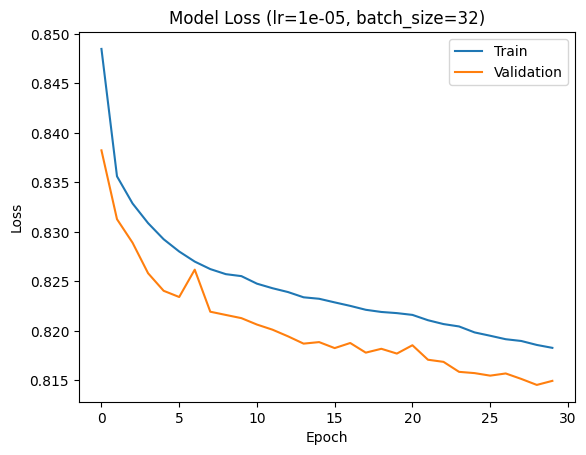

Training model with learning rate=1e-05 and batch size=64
Epoch 1/30
15014/15014 [==============================] - 45s 3ms/step - loss: 0.8463 - mean_absolute_error: 0.5922 - val_loss: 0.8314 - val_mean_absolute_error: 0.5819
Epoch 2/30
15014/15014 [==============================] - 43s 3ms/step - loss: 0.8303 - mean_absolute_error: 0.5848 - val_loss: 0.8246 - val_mean_absolute_error: 0.5824
Epoch 3/30
15014/15014 [==============================] - 44s 3ms/step - loss: 0.8265 - mean_absolute_error: 0.5828 - val_loss: 0.8219 - val_mean_absolute_error: 0.5788
Epoch 4/30
15014/15014 [==============================] - 45s 3ms/step - loss: 0.8231 - mean_absolute_error: 0.5809 - val_loss: 0.8191 - val_mean_absolute_error: 0.5781
Epoch 5/30
15014/15014 [==============================] - 44s 3ms/step - loss: 0.8209 - mean_absolute_error: 0.5799 - val_loss: 0.8175 - val_mean_absolute_error: 0.5801
Epoch 6/30
15014/15014 [==============================] - 45s 3ms/step - loss: 0.8191 - mean_abso

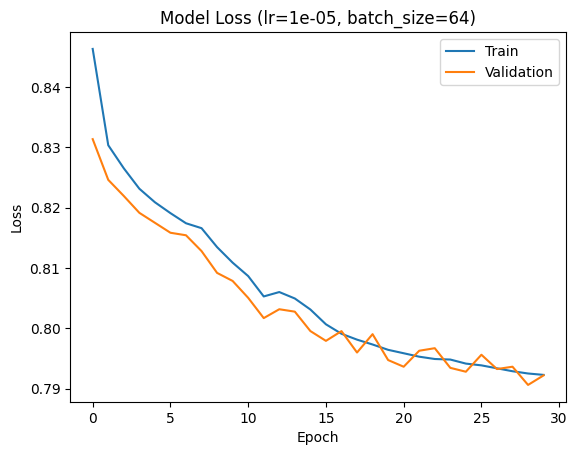

Training model with learning rate=0.0001 and batch size=32
Epoch 1/30
30028/30028 [==============================] - 87s 3ms/step - loss: 0.8445 - mean_absolute_error: 0.5967 - val_loss: 0.8396 - val_mean_absolute_error: 0.5805
Epoch 2/30
30028/30028 [==============================] - 87s 3ms/step - loss: 0.8416 - mean_absolute_error: 0.5956 - val_loss: 0.8392 - val_mean_absolute_error: 0.5781
Epoch 3/30
30028/30028 [==============================] - 88s 3ms/step - loss: 0.8388 - mean_absolute_error: 0.5939 - val_loss: 0.8360 - val_mean_absolute_error: 0.5825
Epoch 4/30
30028/30028 [==============================] - 83s 3ms/step - loss: 0.8374 - mean_absolute_error: 0.5933 - val_loss: 0.8312 - val_mean_absolute_error: 0.5949
Epoch 5/30
30028/30028 [==============================] - 87s 3ms/step - loss: 0.8324 - mean_absolute_error: 0.5932 - val_loss: 0.8292 - val_mean_absolute_error: 0.5927
Epoch 6/30
30028/30028 [==============================] - 87s 3ms/step - loss: 0.8335 - mean_abs

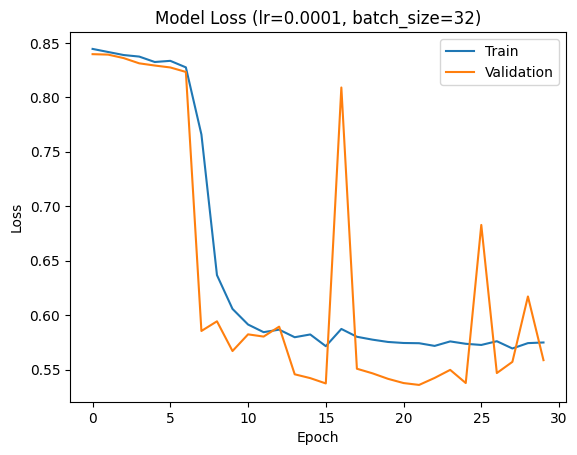

Training model with learning rate=0.0001 and batch size=64
Epoch 1/30
15014/15014 [==============================] - 19s 1ms/step - loss: 0.8190 - mean_absolute_error: 0.5803 - val_loss: 0.8126 - val_mean_absolute_error: 0.5639
Epoch 2/30
15014/15014 [==============================] - 18s 1ms/step - loss: 0.8113 - mean_absolute_error: 0.5776 - val_loss: 0.8035 - val_mean_absolute_error: 0.5666
Epoch 3/30
15014/15014 [==============================] - 18s 1ms/step - loss: 0.8085 - mean_absolute_error: 0.5769 - val_loss: 0.8069 - val_mean_absolute_error: 0.5703
Epoch 4/30
15014/15014 [==============================] - 18s 1ms/step - loss: 0.8054 - mean_absolute_error: 0.5760 - val_loss: 0.8011 - val_mean_absolute_error: 0.5706
Epoch 5/30
15014/15014 [==============================] - 18s 1ms/step - loss: 0.8010 - mean_absolute_error: 0.5742 - val_loss: 0.7986 - val_mean_absolute_error: 0.5807
Epoch 6/30
15014/15014 [==============================] - 17s 1ms/step - loss: 0.8007 - mean_abs

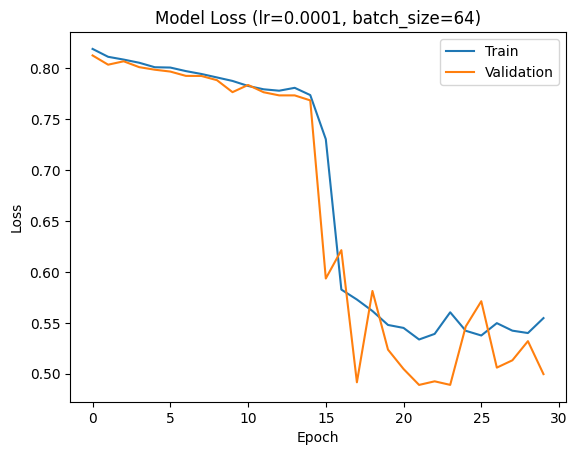

Training model with learning rate=0.001 and batch size=32
Epoch 1/30
30028/30028 [==============================] - 48s 2ms/step - loss: 0.8564 - mean_absolute_error: 0.6022 - val_loss: 0.8489 - val_mean_absolute_error: 0.6006
Epoch 2/30
30028/30028 [==============================] - 34s 1ms/step - loss: 0.8544 - mean_absolute_error: 0.6012 - val_loss: 0.8503 - val_mean_absolute_error: 0.6059
Epoch 3/30
30028/30028 [==============================] - 34s 1ms/step - loss: 0.8553 - mean_absolute_error: 0.6017 - val_loss: 0.8499 - val_mean_absolute_error: 0.5989
Epoch 4/30
30028/30028 [==============================] - 40s 1ms/step - loss: 0.8551 - mean_absolute_error: 0.6018 - val_loss: 0.8608 - val_mean_absolute_error: 0.6329
Epoch 5/30
30028/30028 [==============================] - 34s 1ms/step - loss: 0.8550 - mean_absolute_error: 0.6016 - val_loss: 0.8531 - val_mean_absolute_error: 0.6128
Epoch 6/30
30028/30028 [==============================] - 41s 1ms/step - loss: 0.8547 - mean_abso

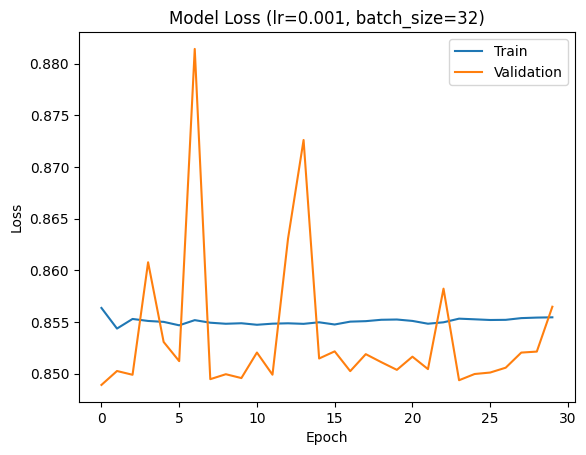

Training model with learning rate=0.001 and batch size=64
Epoch 1/30
15014/15014 [==============================] - 26s 2ms/step - loss: 0.8483 - mean_absolute_error: 0.5976 - val_loss: 0.8452 - val_mean_absolute_error: 0.5925
Epoch 2/30
15014/15014 [==============================] - 23s 2ms/step - loss: 0.8454 - mean_absolute_error: 0.5960 - val_loss: 0.8412 - val_mean_absolute_error: 0.5928
Epoch 3/30
15014/15014 [==============================] - 20s 1ms/step - loss: 0.8457 - mean_absolute_error: 0.5959 - val_loss: 0.8467 - val_mean_absolute_error: 0.5819
Epoch 4/30
15014/15014 [==============================] - 19s 1ms/step - loss: 0.8444 - mean_absolute_error: 0.5944 - val_loss: 0.8408 - val_mean_absolute_error: 0.5974
Epoch 5/30
15014/15014 [==============================] - 21s 1ms/step - loss: 0.8447 - mean_absolute_error: 0.5947 - val_loss: 0.8422 - val_mean_absolute_error: 0.5923
Epoch 6/30
15014/15014 [==============================] - 20s 1ms/step - loss: 0.8445 - mean_abso

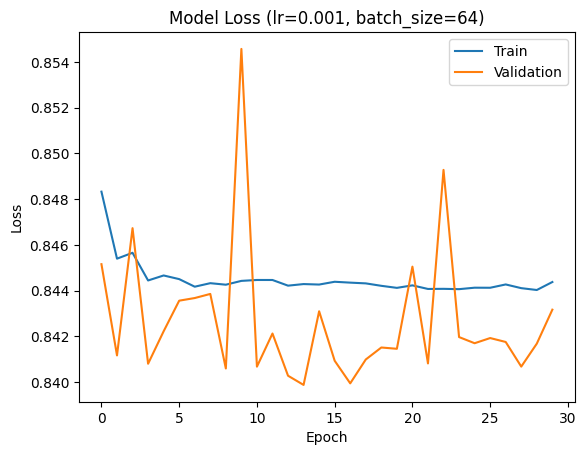

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from sklearn.metrics import r2_score

learning_rates = [1e-5, 1e-4, 0.001]
batch_sizes = [32, 64]

results = {}

for lr in learning_rates:
    for batch_size in batch_sizes:
        print(f"Training model with learning rate={lr} and batch size={batch_size}")
        
        # Define the neural network architecture
        model = Sequential([
            Dense(32, input_shape=(X_all_train.shape[1],), activation='tanh'),
            Dense(64, activation='tanh'),
            Dense(64, activation='tanh'),
            Dense(1)
        ])
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        # Compile the model
        model.compile(optimizer=optimizer,
                      loss='mean_squared_error',
                      metrics=['mean_absolute_error'])
        
        # Train the model
        history = model.fit(X_all_train, y_all_train, epochs=30, batch_size=batch_size, validation_split=0.2, verbose=1)
        
        # Evaluate the model on test data
        print("Evaluate on test data")
        results_lr_batch = model.evaluate(X_all_test, y_all_test)
        print("Test loss, Test acc:", results_lr_batch)
        
        # Making predictions
        predictions = model.predict(X_all_test)
        r2 = r2_score(y_all_test, predictions)
        print("Predictions shape:", predictions.shape)
        print("R^2 Score:", r2)
        
        # Get the first 5 predicted values
        #predicted_values = predictions[:5]
        #print("First 5 Predicted Values:", predicted_values)
        
        # Store results for this scenario
        results[(lr, batch_size)] = {
            'loss': results_lr_batch[0],
            'mae': results_lr_batch[1],
            'predictions': predictions,
            'r2': r2
        }
        
        # Plot the loss values over epochs
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title(f'Model Loss (lr={lr}, batch_size={batch_size})')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.show()

### Training with 10 selected features

Training model with learning rate=1e-05 and batch size=32
Epoch 1/30
30028/30028 [==============================] - 32s 1ms/step - loss: 1.0016 - mean_absolute_error: 0.6725 - val_loss: 0.9991 - val_mean_absolute_error: 0.6760
Epoch 2/30
30028/30028 [==============================] - 38s 1ms/step - loss: 1.0000 - mean_absolute_error: 0.6725 - val_loss: 0.9990 - val_mean_absolute_error: 0.6719
Epoch 3/30
30028/30028 [==============================] - 37s 1ms/step - loss: 1.0000 - mean_absolute_error: 0.6725 - val_loss: 0.9990 - val_mean_absolute_error: 0.6717
Epoch 4/30
30028/30028 [==============================] - 38s 1ms/step - loss: 1.0000 - mean_absolute_error: 0.6725 - val_loss: 0.9994 - val_mean_absolute_error: 0.6676
Epoch 5/30
30028/30028 [==============================] - 34s 1ms/step - loss: 1.0000 - mean_absolute_error: 0.6725 - val_loss: 0.9993 - val_mean_absolute_error: 0.6782
Epoch 6/30
30028/30028 [==============================] - 44s 1ms/step - loss: 1.0000 - mean_abso

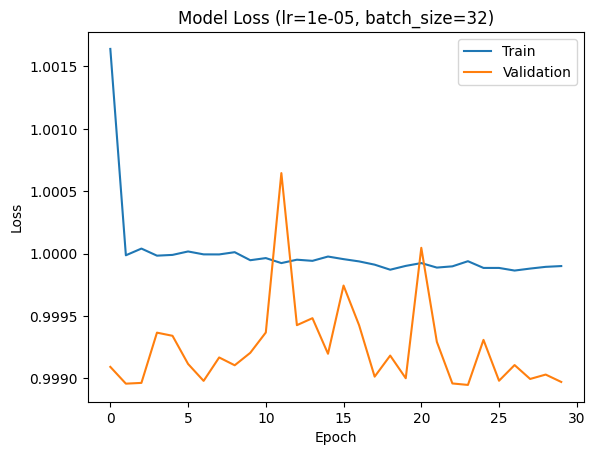

Training model with learning rate=1e-05 and batch size=64
Epoch 1/30
15014/15014 [==============================] - 19s 1ms/step - loss: 0.9195 - mean_absolute_error: 0.6453 - val_loss: 0.9120 - val_mean_absolute_error: 0.6405
Epoch 2/30
15014/15014 [==============================] - 24s 2ms/step - loss: 0.9092 - mean_absolute_error: 0.6421 - val_loss: 0.9052 - val_mean_absolute_error: 0.6417
Epoch 3/30
15014/15014 [==============================] - 24s 2ms/step - loss: 0.9036 - mean_absolute_error: 0.6400 - val_loss: 0.9002 - val_mean_absolute_error: 0.6429
Epoch 4/30
15014/15014 [==============================] - 21s 1ms/step - loss: 0.8989 - mean_absolute_error: 0.6385 - val_loss: 0.8956 - val_mean_absolute_error: 0.6422
Epoch 5/30
15014/15014 [==============================] - 16s 1ms/step - loss: 0.8938 - mean_absolute_error: 0.6371 - val_loss: 0.8909 - val_mean_absolute_error: 0.6284
Epoch 6/30
15014/15014 [==============================] - 17s 1ms/step - loss: 0.8875 - mean_abso

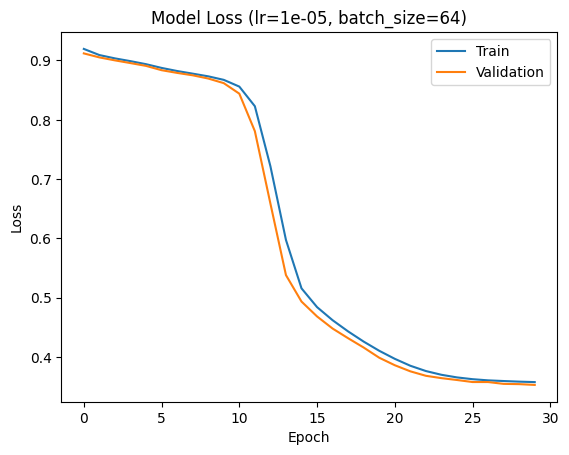

Training model with learning rate=0.0001 and batch size=32
Epoch 1/30
30028/30028 [==============================] - 39s 1ms/step - loss: 0.4779 - mean_absolute_error: 0.4370 - val_loss: 0.3596 - val_mean_absolute_error: 0.3936
Epoch 2/30
30028/30028 [==============================] - 30s 990us/step - loss: 0.3715 - mean_absolute_error: 0.3888 - val_loss: 0.3490 - val_mean_absolute_error: 0.3813
Epoch 3/30
30028/30028 [==============================] - 30s 1ms/step - loss: 0.3702 - mean_absolute_error: 0.3889 - val_loss: 0.3604 - val_mean_absolute_error: 0.3673
Epoch 4/30
30028/30028 [==============================] - 45s 2ms/step - loss: 0.3650 - mean_absolute_error: 0.3863 - val_loss: 0.4223 - val_mean_absolute_error: 0.3950
Epoch 5/30
30028/30028 [==============================] - 36s 1ms/step - loss: 0.3639 - mean_absolute_error: 0.3862 - val_loss: 0.3403 - val_mean_absolute_error: 0.3677
Epoch 6/30
30028/30028 [==============================] - 31s 1ms/step - loss: 0.3630 - mean_a

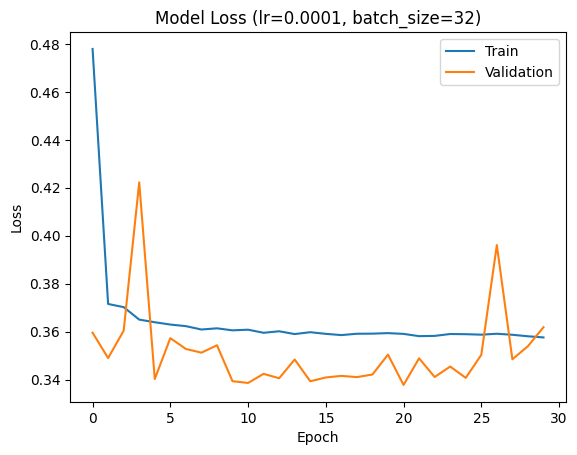

Training model with learning rate=0.0001 and batch size=64
Epoch 1/30
15014/15014 [==============================] - 23s 1ms/step - loss: 0.6083 - mean_absolute_error: 0.5090 - val_loss: 0.4078 - val_mean_absolute_error: 0.3972
Epoch 2/30
15014/15014 [==============================] - 21s 1ms/step - loss: 0.3758 - mean_absolute_error: 0.3923 - val_loss: 0.3601 - val_mean_absolute_error: 0.3888
Epoch 3/30
15014/15014 [==============================] - 16s 1ms/step - loss: 0.3687 - mean_absolute_error: 0.3892 - val_loss: 0.4021 - val_mean_absolute_error: 0.4524
Epoch 4/30
15014/15014 [==============================] - 19s 1ms/step - loss: 0.3662 - mean_absolute_error: 0.3873 - val_loss: 0.3496 - val_mean_absolute_error: 0.3710
Epoch 5/30
15014/15014 [==============================] - 17s 1ms/step - loss: 0.3614 - mean_absolute_error: 0.3841 - val_loss: 0.3565 - val_mean_absolute_error: 0.3660
Epoch 6/30
15014/15014 [==============================] - 17s 1ms/step - loss: 0.3594 - mean_abs

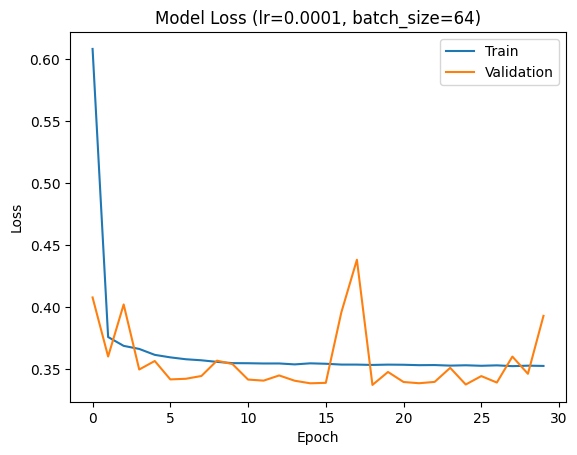

Training model with learning rate=0.001 and batch size=32
Epoch 1/30
30028/30028 [==============================] - 38s 1ms/step - loss: 1.0046 - mean_absolute_error: 0.6748 - val_loss: 1.0012 - val_mean_absolute_error: 0.6615
Epoch 2/30
30028/30028 [==============================] - 34s 1ms/step - loss: 1.0044 - mean_absolute_error: 0.6747 - val_loss: 0.9992 - val_mean_absolute_error: 0.6690
Epoch 3/30
30028/30028 [==============================] - 35s 1ms/step - loss: 1.0044 - mean_absolute_error: 0.6746 - val_loss: 1.0026 - val_mean_absolute_error: 0.6587
Epoch 4/30
30028/30028 [==============================] - 40s 1ms/step - loss: 1.0044 - mean_absolute_error: 0.6748 - val_loss: 0.9998 - val_mean_absolute_error: 0.6656
Epoch 5/30
30028/30028 [==============================] - 39s 1ms/step - loss: 1.0048 - mean_absolute_error: 0.6750 - val_loss: 1.0085 - val_mean_absolute_error: 0.7030
Epoch 6/30
30028/30028 [==============================] - 31s 1ms/step - loss: 1.0048 - mean_abso

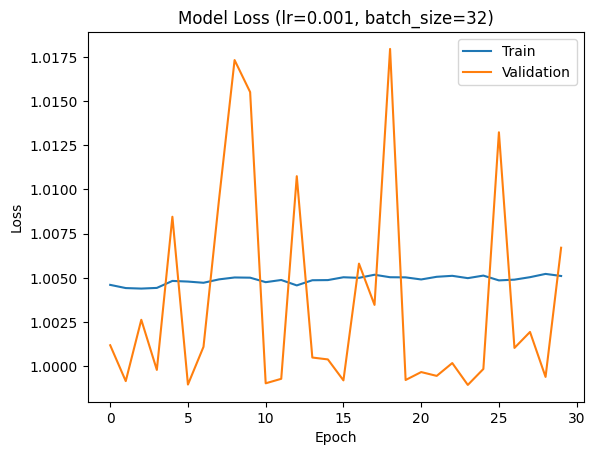

Training model with learning rate=0.001 and batch size=64
Epoch 1/30
15014/15014 [==============================] - 25s 2ms/step - loss: 0.5559 - mean_absolute_error: 0.4835 - val_loss: 0.5223 - val_mean_absolute_error: 0.4575
Epoch 2/30
15014/15014 [==============================] - 20s 1ms/step - loss: 0.4224 - mean_absolute_error: 0.4191 - val_loss: 0.3616 - val_mean_absolute_error: 0.3863
Epoch 3/30
15014/15014 [==============================] - 17s 1ms/step - loss: 0.4174 - mean_absolute_error: 0.4158 - val_loss: 0.3761 - val_mean_absolute_error: 0.3771
Epoch 4/30
15014/15014 [==============================] - 18s 1ms/step - loss: 0.4128 - mean_absolute_error: 0.4137 - val_loss: 0.3968 - val_mean_absolute_error: 0.3762
Epoch 5/30
15014/15014 [==============================] - 17s 1ms/step - loss: 0.4147 - mean_absolute_error: 0.4148 - val_loss: 0.3702 - val_mean_absolute_error: 0.3746
Epoch 6/30
15014/15014 [==============================] - 17s 1ms/step - loss: 0.4117 - mean_abso

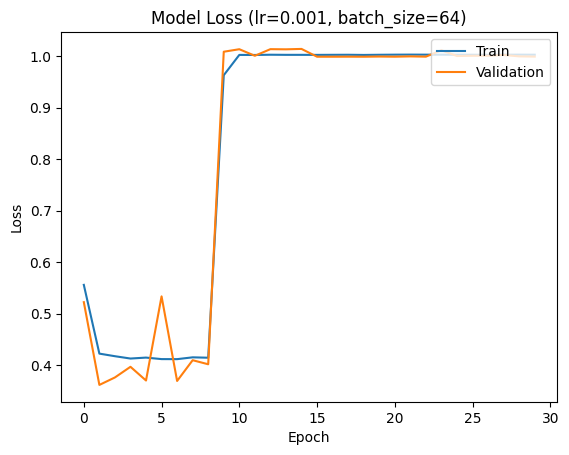

In [14]:
learning_rates = [1e-5, 1e-4, 0.001]
batch_sizes = [32, 64]

results = {}

for lr in learning_rates:
    for batch_size in batch_sizes:
        print(f"Training model with learning rate={lr} and batch size={batch_size}")
        
        # Define the neural network architecture
        model = Sequential([
            Dense(32, input_shape=(X_select_train.shape[1],), activation='tanh'),
            Dense(64, activation='tanh'),
            Dense(64, activation='tanh'),
            Dense(1)
        ])
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        # Compile the model
        model.compile(optimizer=optimizer,
                      loss='mean_squared_error',
                      metrics=['mean_absolute_error'])
        
        # Train the model
        history = model.fit(X_select_train, y_select_train, epochs=30, batch_size=batch_size, validation_split=0.2, verbose=1)
        
        # Evaluate the model on test data
        print("Evaluate on test data")
        results_lr_batch = model.evaluate(X_select_test, y_select_test)
        print("Test loss, Test acc:", results_lr_batch)
        
        # Making predictions
        predictions = model.predict(X_select_test)
        r2 = r2_score(y_select_test, predictions)
        print("Predictions shape:", predictions.shape)
        print("R^2 Score:", r2)

        # Get the first 5 predicted values
        #predicted_values = predictions[:5]
        #print("First 5 Predicted Values:", predicted_values)
        
        # Store results for this scenario
        results[(lr, batch_size)] = {
            'loss': results_lr_batch[0],
            'mae': results_lr_batch[1],
            'predictions': predictions,
            'r2': r2
        }
        
        # Plot the loss values over epochs
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title(f'Model Loss (lr={lr}, batch_size={batch_size})')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.show()

### Adding more neurons to the input and hidden layers

Training model with learning rate=1e-05 and batch size=32
Epoch 1/30
30028/30028 [==============================] - 44s 1ms/step - loss: 1.0013 - mean_absolute_error: 0.6727 - val_loss: 0.9989 - val_mean_absolute_error: 0.6725
Epoch 2/30
30028/30028 [==============================] - 38s 1ms/step - loss: 1.0003 - mean_absolute_error: 0.6727 - val_loss: 0.9990 - val_mean_absolute_error: 0.6736
Epoch 3/30
30028/30028 [==============================] - 42s 1ms/step - loss: 1.0003 - mean_absolute_error: 0.6726 - val_loss: 0.9990 - val_mean_absolute_error: 0.6708
Epoch 4/30
30028/30028 [==============================] - 47s 2ms/step - loss: 1.0003 - mean_absolute_error: 0.6726 - val_loss: 0.9990 - val_mean_absolute_error: 0.6749
Epoch 5/30
30028/30028 [==============================] - 47s 2ms/step - loss: 1.0002 - mean_absolute_error: 0.6726 - val_loss: 0.9996 - val_mean_absolute_error: 0.6796
Epoch 6/30
30028/30028 [==============================] - 43s 1ms/step - loss: 1.0003 - mean_abso

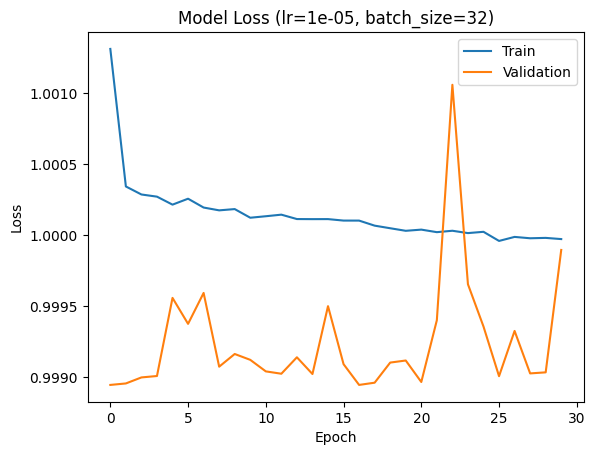

Training model with learning rate=1e-05 and batch size=64
Epoch 1/30
15014/15014 [==============================] - 28s 2ms/step - loss: 0.9122 - mean_absolute_error: 0.6430 - val_loss: 0.8949 - val_mean_absolute_error: 0.6376
Epoch 2/30
15014/15014 [==============================] - 26s 2ms/step - loss: 0.8914 - mean_absolute_error: 0.6352 - val_loss: 0.8862 - val_mean_absolute_error: 0.6329
Epoch 3/30
15014/15014 [==============================] - 23s 2ms/step - loss: 0.8831 - mean_absolute_error: 0.6320 - val_loss: 0.8785 - val_mean_absolute_error: 0.6310
Epoch 4/30
15014/15014 [==============================] - 21s 1ms/step - loss: 0.8753 - mean_absolute_error: 0.6290 - val_loss: 0.8700 - val_mean_absolute_error: 0.6347
Epoch 5/30
15014/15014 [==============================] - 23s 2ms/step - loss: 0.8640 - mean_absolute_error: 0.6240 - val_loss: 0.8549 - val_mean_absolute_error: 0.6192
Epoch 6/30
15014/15014 [==============================] - 21s 1ms/step - loss: 0.8407 - mean_abso

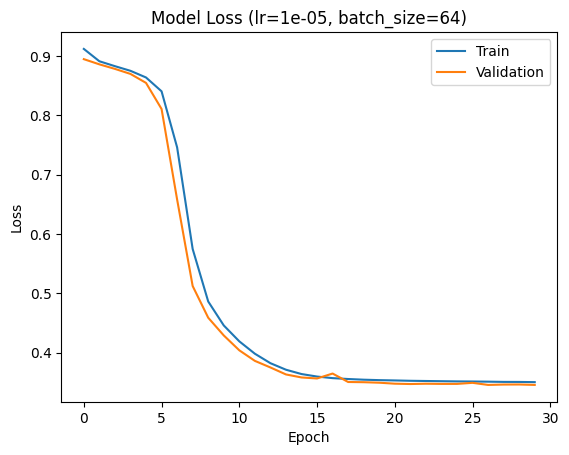

Training model with learning rate=0.0001 and batch size=32
Epoch 1/30
30028/30028 [==============================] - 50s 2ms/step - loss: 1.0035 - mean_absolute_error: 0.6742 - val_loss: 0.9990 - val_mean_absolute_error: 0.6748
Epoch 2/30
30028/30028 [==============================] - 43s 1ms/step - loss: 1.0014 - mean_absolute_error: 0.6732 - val_loss: 0.9991 - val_mean_absolute_error: 0.6697
Epoch 3/30
30028/30028 [==============================] - 38s 1ms/step - loss: 1.0009 - mean_absolute_error: 0.6730 - val_loss: 0.9990 - val_mean_absolute_error: 0.6715
Epoch 4/30
30028/30028 [==============================] - 44s 1ms/step - loss: 1.0007 - mean_absolute_error: 0.6728 - val_loss: 1.0001 - val_mean_absolute_error: 0.6822
Epoch 5/30
30028/30028 [==============================] - 41s 1ms/step - loss: 1.0003 - mean_absolute_error: 0.6727 - val_loss: 0.9993 - val_mean_absolute_error: 0.6682
Epoch 6/30
30028/30028 [==============================] - 43s 1ms/step - loss: 1.0002 - mean_abs

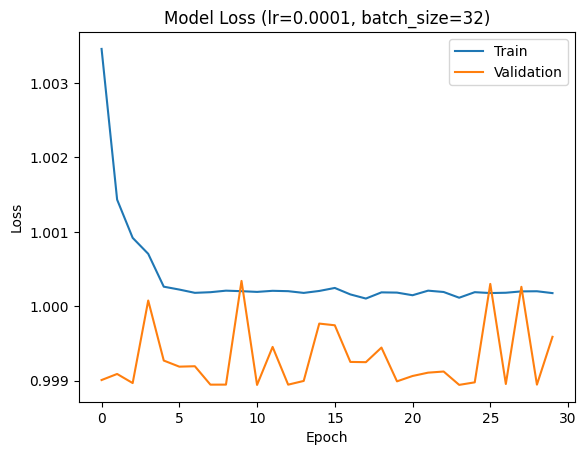

Training model with learning rate=0.0001 and batch size=64
Epoch 1/30
15014/15014 [==============================] - 25s 2ms/step - loss: 0.7713 - mean_absolute_error: 0.5934 - val_loss: 0.5329 - val_mean_absolute_error: 0.4889
Epoch 2/30
15014/15014 [==============================] - 23s 2ms/step - loss: 0.4028 - mean_absolute_error: 0.4095 - val_loss: 0.3610 - val_mean_absolute_error: 0.3745
Epoch 3/30
15014/15014 [==============================] - 23s 2ms/step - loss: 0.3670 - mean_absolute_error: 0.3881 - val_loss: 0.3545 - val_mean_absolute_error: 0.3940
Epoch 4/30
15014/15014 [==============================] - 23s 2ms/step - loss: 0.3617 - mean_absolute_error: 0.3847 - val_loss: 0.3621 - val_mean_absolute_error: 0.4079
Epoch 5/30
15014/15014 [==============================] - 20s 1ms/step - loss: 0.3585 - mean_absolute_error: 0.3826 - val_loss: 0.3447 - val_mean_absolute_error: 0.3866
Epoch 6/30
15014/15014 [==============================] - 21s 1ms/step - loss: 0.3575 - mean_abs

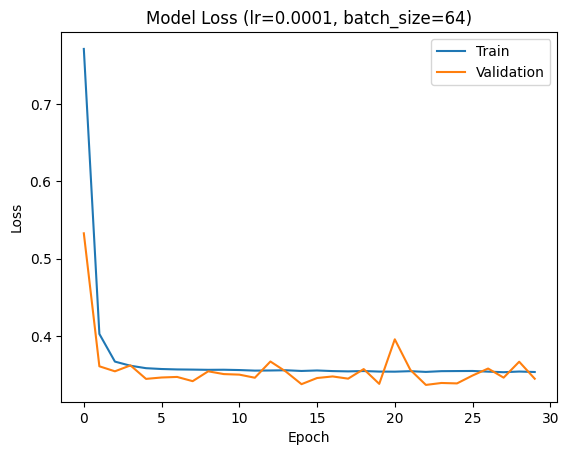

Training model with learning rate=0.001 and batch size=32
Epoch 1/30
30028/30028 [==============================] - 40s 1ms/step - loss: 1.0055 - mean_absolute_error: 0.6752 - val_loss: 1.0010 - val_mean_absolute_error: 0.6856
Epoch 2/30
30028/30028 [==============================] - 39s 1ms/step - loss: 1.0039 - mean_absolute_error: 0.6744 - val_loss: 1.0060 - val_mean_absolute_error: 0.6543
Epoch 3/30
30028/30028 [==============================] - 40s 1ms/step - loss: 1.0036 - mean_absolute_error: 0.6743 - val_loss: 1.0031 - val_mean_absolute_error: 0.6580
Epoch 4/30
30028/30028 [==============================] - 37s 1ms/step - loss: 1.0040 - mean_absolute_error: 0.6745 - val_loss: 1.0006 - val_mean_absolute_error: 0.6630
Epoch 5/30
30028/30028 [==============================] - 48s 2ms/step - loss: 1.0037 - mean_absolute_error: 0.6744 - val_loss: 1.0030 - val_mean_absolute_error: 0.6916
Epoch 6/30
30028/30028 [==============================] - 48s 2ms/step - loss: 1.0034 - mean_abso

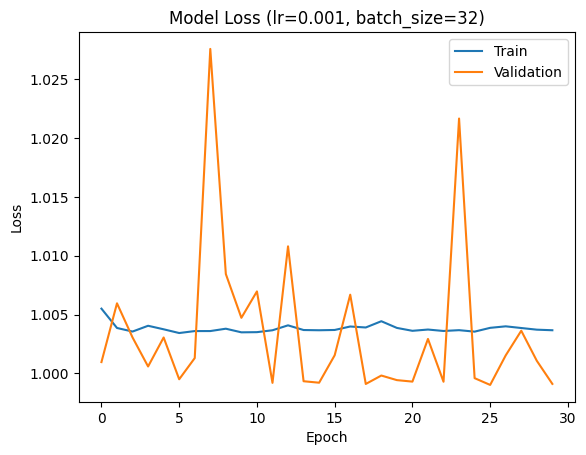

Training model with learning rate=0.001 and batch size=64
Epoch 1/30
15014/15014 [==============================] - 25s 2ms/step - loss: 1.0050 - mean_absolute_error: 0.6749 - val_loss: 1.0004 - val_mean_absolute_error: 0.6835
Epoch 2/30
15014/15014 [==============================] - 24s 2ms/step - loss: 1.0040 - mean_absolute_error: 0.6745 - val_loss: 1.0043 - val_mean_absolute_error: 0.6562
Epoch 3/30
15014/15014 [==============================] - 27s 2ms/step - loss: 1.0040 - mean_absolute_error: 0.6745 - val_loss: 1.0034 - val_mean_absolute_error: 0.6575
Epoch 4/30
15014/15014 [==============================] - 25s 2ms/step - loss: 1.0043 - mean_absolute_error: 0.6746 - val_loss: 0.9996 - val_mean_absolute_error: 0.6666
Epoch 5/30
15014/15014 [==============================] - 27s 2ms/step - loss: 1.0049 - mean_absolute_error: 0.6750 - val_loss: 1.0093 - val_mean_absolute_error: 0.6513
Epoch 6/30
15014/15014 [==============================] - 23s 2ms/step - loss: 1.0050 - mean_abso

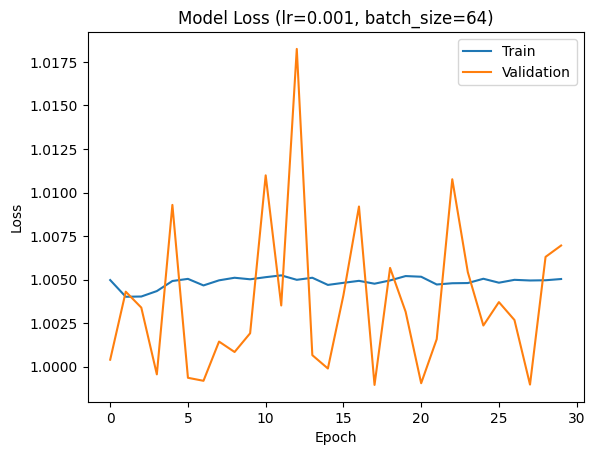

In [13]:
learning_rates = [1e-5, 1e-4, 0.001]
batch_sizes = [32, 64]

results = {}  # Dictionary to store results for each scenario

for lr in learning_rates:
    for batch_size in batch_sizes:
        print(f"Training model with learning rate={lr} and batch size={batch_size}")
        
        # Define the neural network architecture
        model = Sequential([
            Dense(48, input_shape=(X_select_train.shape[1],), activation='tanh'),
            Dense(96, activation='tanh'),
            Dense(96, activation='tanh'),
            Dense(1)
        ])
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        # Compile the model
        model.compile(optimizer=optimizer,
                      loss='mean_squared_error',
                      metrics=['mean_absolute_error'])
        
        # Train the model
        history = model.fit(X_select_train, y_select_train, epochs=30, batch_size=batch_size, validation_split=0.2, verbose=1)
        
        # Evaluate the model on test data
        print("Evaluate on test data")
        results_lr_batch = model.evaluate(X_select_test, y_select_test)
        print("Test loss, Test acc:", results_lr_batch)
        
        # Making predictions
        predictions = model.predict(X_select_test)
        r2 = r2_score(y_select_test, predictions)
        print("Predictions shape:", predictions.shape)
        print("R^2 Score:", r2)

        # Get the first 5 predicted values
        #predicted_values = predictions[:5]
        #print("First 5 Predicted Values:", predicted_values)
        
        # Store results for this scenario
        results[(lr, batch_size)] = {
            'loss': results_lr_batch[0],
            'mae': results_lr_batch[1],
            'predictions': predictions,
            'r2': r2
        }
        
        # Plot the loss values over epochs
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title(f'Model Loss (lr={lr}, batch_size={batch_size})')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.show()

### Training models with sigmoid as the activation function

Training model with learning rate=1e-05 and batch size=32
Epoch 1/30
30028/30028 [==============================] - 47s 2ms/step - loss: 0.9913 - mean_absolute_error: 0.6696 - val_loss: 0.9803 - val_mean_absolute_error: 0.6722
Epoch 2/30
30028/30028 [==============================] - 47s 2ms/step - loss: 0.9612 - mean_absolute_error: 0.6592 - val_loss: 0.9333 - val_mean_absolute_error: 0.6497
Epoch 3/30
30028/30028 [==============================] - 41s 1ms/step - loss: 0.8762 - mean_absolute_error: 0.6296 - val_loss: 0.7894 - val_mean_absolute_error: 0.5991
Epoch 4/30
30028/30028 [==============================] - 37s 1ms/step - loss: 0.6689 - mean_absolute_error: 0.5376 - val_loss: 0.5576 - val_mean_absolute_error: 0.4811
Epoch 5/30
30028/30028 [==============================] - 38s 1ms/step - loss: 0.5068 - mean_absolute_error: 0.4515 - val_loss: 0.4667 - val_mean_absolute_error: 0.4383
Epoch 6/30
30028/30028 [==============================] - 37s 1ms/step - loss: 0.4408 - mean_abso

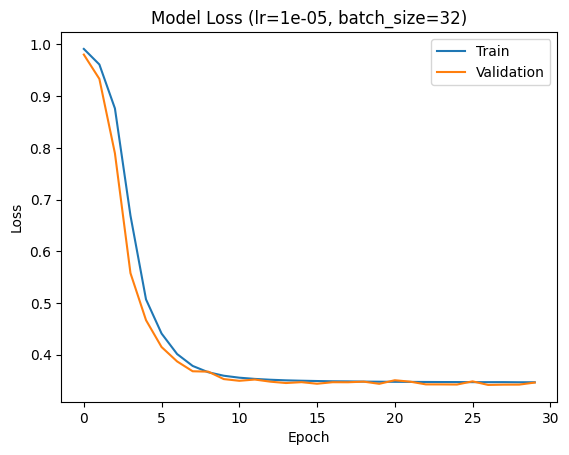

Training model with learning rate=1e-05 and batch size=64
Epoch 1/30
15014/15014 [==============================] - 17s 1ms/step - loss: 0.9920 - mean_absolute_error: 0.6658 - val_loss: 0.9616 - val_mean_absolute_error: 0.6608
Epoch 2/30
15014/15014 [==============================] - 22s 1ms/step - loss: 0.9296 - mean_absolute_error: 0.6471 - val_loss: 0.8910 - val_mean_absolute_error: 0.6347
Epoch 3/30
15014/15014 [==============================] - 22s 1ms/step - loss: 0.8538 - mean_absolute_error: 0.6184 - val_loss: 0.8141 - val_mean_absolute_error: 0.6063
Epoch 4/30
15014/15014 [==============================] - 25s 2ms/step - loss: 0.7789 - mean_absolute_error: 0.5855 - val_loss: 0.7382 - val_mean_absolute_error: 0.5663
Epoch 5/30
15014/15014 [==============================] - 22s 1ms/step - loss: 0.6918 - mean_absolute_error: 0.5457 - val_loss: 0.6334 - val_mean_absolute_error: 0.5191
Epoch 6/30
15014/15014 [==============================] - 20s 1ms/step - loss: 0.5821 - mean_abso

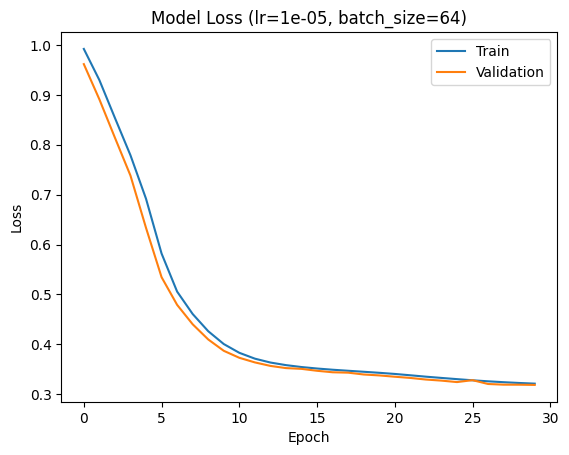

Training model with learning rate=0.0001 and batch size=32
Epoch 1/30
30028/30028 [==============================] - 33s 1ms/step - loss: 1.0007 - mean_absolute_error: 0.6729 - val_loss: 1.0002 - val_mean_absolute_error: 0.6640
Epoch 2/30
30028/30028 [==============================] - 38s 1ms/step - loss: 1.0005 - mean_absolute_error: 0.6728 - val_loss: 0.9993 - val_mean_absolute_error: 0.6782
Epoch 3/30
30028/30028 [==============================] - 31s 1ms/step - loss: 1.0005 - mean_absolute_error: 0.6727 - val_loss: 0.9991 - val_mean_absolute_error: 0.6760
Epoch 4/30
30028/30028 [==============================] - 35s 1ms/step - loss: 1.0004 - mean_absolute_error: 0.6727 - val_loss: 0.9995 - val_mean_absolute_error: 0.6793
Epoch 5/30
30028/30028 [==============================] - 42s 1ms/step - loss: 1.0003 - mean_absolute_error: 0.6727 - val_loss: 0.9999 - val_mean_absolute_error: 0.6812
Epoch 6/30
30028/30028 [==============================] - 34s 1ms/step - loss: 1.0002 - mean_abs

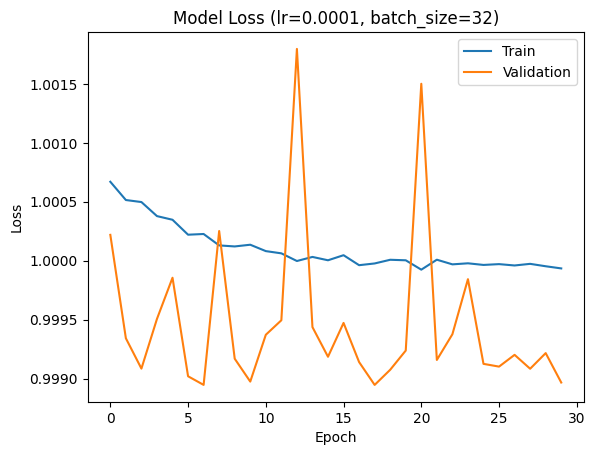

Training model with learning rate=0.0001 and batch size=64
Epoch 1/30
15014/15014 [==============================] - 26s 2ms/step - loss: 0.7935 - mean_absolute_error: 0.5823 - val_loss: 0.4107 - val_mean_absolute_error: 0.4038
Epoch 2/30
15014/15014 [==============================] - 22s 1ms/step - loss: 0.3749 - mean_absolute_error: 0.3824 - val_loss: 0.3481 - val_mean_absolute_error: 0.3695
Epoch 3/30
15014/15014 [==============================] - 19s 1ms/step - loss: 0.3573 - mean_absolute_error: 0.3760 - val_loss: 0.3651 - val_mean_absolute_error: 0.4032
Epoch 4/30
15014/15014 [==============================] - 18s 1ms/step - loss: 0.3558 - mean_absolute_error: 0.3771 - val_loss: 0.3433 - val_mean_absolute_error: 0.3684
Epoch 5/30
15014/15014 [==============================] - 20s 1ms/step - loss: 0.3556 - mean_absolute_error: 0.3778 - val_loss: 0.3594 - val_mean_absolute_error: 0.3658
Epoch 6/30
15014/15014 [==============================] - 24s 2ms/step - loss: 0.3556 - mean_abs

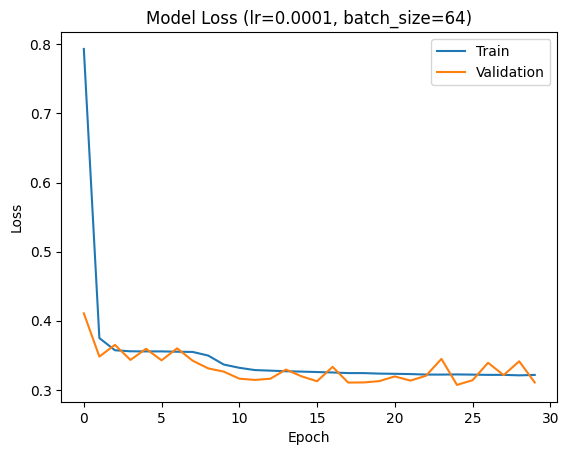

Training model with learning rate=0.001 and batch size=32
Epoch 1/30
30028/30028 [==============================] - 47s 2ms/step - loss: 1.0031 - mean_absolute_error: 0.6740 - val_loss: 0.9995 - val_mean_absolute_error: 0.6794
Epoch 2/30
30028/30028 [==============================] - 44s 1ms/step - loss: 1.0024 - mean_absolute_error: 0.6738 - val_loss: 1.0047 - val_mean_absolute_error: 0.6954
Epoch 3/30
30028/30028 [==============================] - 41s 1ms/step - loss: 1.0021 - mean_absolute_error: 0.6735 - val_loss: 0.9990 - val_mean_absolute_error: 0.6710
Epoch 4/30
30028/30028 [==============================] - 40s 1ms/step - loss: 1.0000 - mean_absolute_error: 0.6725 - val_loss: 0.9990 - val_mean_absolute_error: 0.6753
Epoch 5/30
30028/30028 [==============================] - 45s 2ms/step - loss: 0.9998 - mean_absolute_error: 0.6724 - val_loss: 0.9989 - val_mean_absolute_error: 0.6731
Epoch 6/30
30028/30028 [==============================] - 47s 2ms/step - loss: 0.9997 - mean_abso

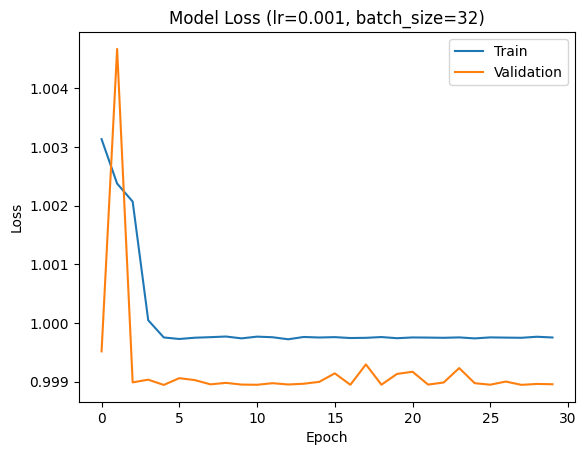

Training model with learning rate=0.001 and batch size=64
Epoch 1/30
15014/15014 [==============================] - 22s 1ms/step - loss: 1.0023 - mean_absolute_error: 0.6736 - val_loss: 1.0001 - val_mean_absolute_error: 0.6643
Epoch 2/30
15014/15014 [==============================] - 20s 1ms/step - loss: 1.0014 - mean_absolute_error: 0.6732 - val_loss: 0.9990 - val_mean_absolute_error: 0.6709
Epoch 3/30
15014/15014 [==============================] - 21s 1ms/step - loss: 1.0011 - mean_absolute_error: 0.6731 - val_loss: 0.9990 - val_mean_absolute_error: 0.6743
Epoch 4/30
15014/15014 [==============================] - 21s 1ms/step - loss: 1.0003 - mean_absolute_error: 0.6727 - val_loss: 0.9990 - val_mean_absolute_error: 0.6705
Epoch 5/30
15014/15014 [==============================] - 21s 1ms/step - loss: 0.9997 - mean_absolute_error: 0.6724 - val_loss: 0.9990 - val_mean_absolute_error: 0.6709
Epoch 6/30
15014/15014 [==============================] - 21s 1ms/step - loss: 0.9997 - mean_abso

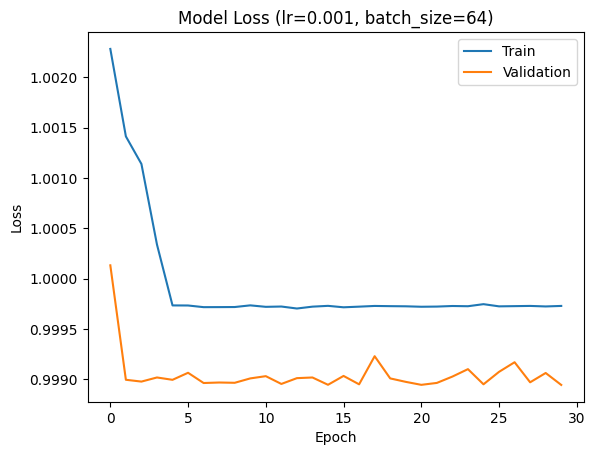

In [13]:
learning_rates = [1e-5, 1e-4, 0.001]
batch_sizes = [32, 64]

results = {}  # Dictionary to store results for each scenario

for lr in learning_rates:
    for batch_size in batch_sizes:
        print(f"Training model with learning rate={lr} and batch size={batch_size}")
        
        # Define the neural network architecture
        model = Sequential([
            Dense(32, input_shape=(X_select_train.shape[1],), activation='sigmoid'),
            Dense(64, activation='sigmoid'),
            Dense(64, activation='sigmoid'),
            Dense(1)
        ])
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        # Compile the model
        model.compile(optimizer=optimizer,
                      loss='mean_squared_error',
                      metrics=['mean_absolute_error'])
        
        # Train the model
        history = model.fit(X_select_train, y_select_train, epochs=30, batch_size=batch_size, validation_split=0.2, verbose=1)
        
        # Evaluate the model on test data
        print("Evaluate on test data")
        results_lr_batch = model.evaluate(X_select_test, y_select_test)
        print("Test loss, Test acc:", results_lr_batch)
        
        # Making predictions
        predictions = model.predict(X_select_test)
        r2 = r2_score(y_select_test, predictions)
        print("Predictions shape:", predictions.shape)
        print("R^2 Score:", r2)

        # Get the first 5 predicted values
        #predicted_values = predictions[:5]
        #print("First 5 Predicted Values:", predicted_values)
        
        # Store results for this scenario
        results[(lr, batch_size)] = {
            'loss': results_lr_batch[0],
            'mae': results_lr_batch[1],
            'predictions': predictions,
            'r2': r2
        }
        
        # Plot the loss values over epochs
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title(f'Model Loss (lr={lr}, batch_size={batch_size})')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.show()

### Training with 5 features

Training model with learning rate=1e-05 and batch size=32
Epoch 1/30
30028/30028 [==============================] - 43s 1ms/step - loss: 1.0010 - mean_absolute_error: 0.6725 - val_loss: 0.9990 - val_mean_absolute_error: 0.6711
Epoch 2/30
30028/30028 [==============================] - 39s 1ms/step - loss: 1.0000 - mean_absolute_error: 0.6725 - val_loss: 0.9990 - val_mean_absolute_error: 0.6737
Epoch 3/30
30028/30028 [==============================] - 38s 1ms/step - loss: 1.0000 - mean_absolute_error: 0.6725 - val_loss: 0.9997 - val_mean_absolute_error: 0.6660
Epoch 4/30
30028/30028 [==============================] - 45s 2ms/step - loss: 1.0001 - mean_absolute_error: 0.6725 - val_loss: 0.9992 - val_mean_absolute_error: 0.6690
Epoch 5/30
30028/30028 [==============================] - 37s 1ms/step - loss: 1.0000 - mean_absolute_error: 0.6725 - val_loss: 0.9990 - val_mean_absolute_error: 0.6707
Epoch 6/30
30028/30028 [==============================] - 36s 1ms/step - loss: 1.0000 - mean_abso

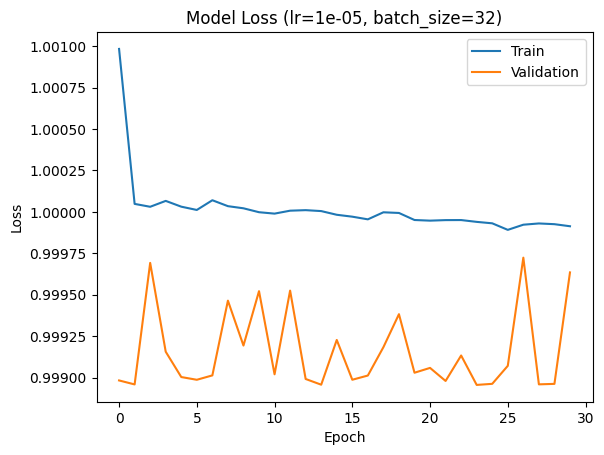

Training model with learning rate=1e-05 and batch size=64
Epoch 1/30
15014/15014 [==============================] - 18s 1ms/step - loss: 0.7134 - mean_absolute_error: 0.5645 - val_loss: 0.5749 - val_mean_absolute_error: 0.5080
Epoch 2/30
15014/15014 [==============================] - 19s 1ms/step - loss: 0.5379 - mean_absolute_error: 0.4836 - val_loss: 0.4988 - val_mean_absolute_error: 0.4687
Epoch 3/30
15014/15014 [==============================] - 20s 1ms/step - loss: 0.4744 - mean_absolute_error: 0.4427 - val_loss: 0.4470 - val_mean_absolute_error: 0.4352
Epoch 4/30
15014/15014 [==============================] - 22s 1ms/step - loss: 0.4349 - mean_absolute_error: 0.4177 - val_loss: 0.4234 - val_mean_absolute_error: 0.4024
Epoch 5/30
15014/15014 [==============================] - 21s 1ms/step - loss: 0.4160 - mean_absolute_error: 0.4076 - val_loss: 0.4150 - val_mean_absolute_error: 0.4270
Epoch 6/30
15014/15014 [==============================] - 19s 1ms/step - loss: 0.4076 - mean_abso

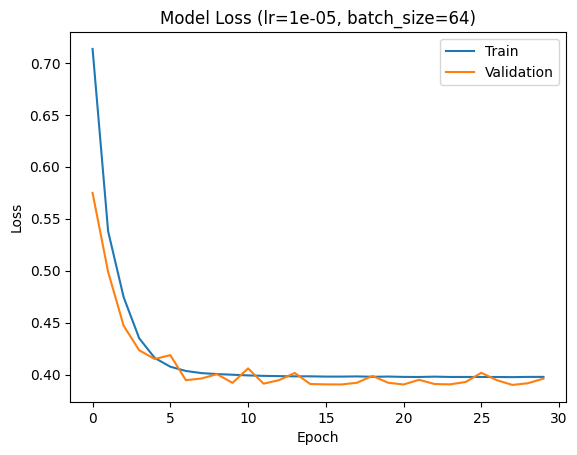

Training model with learning rate=0.0001 and batch size=32
Epoch 1/30
30028/30028 [==============================] - 35s 1ms/step - loss: 1.0061 - mean_absolute_error: 0.6753 - val_loss: 1.0003 - val_mean_absolute_error: 0.6830
Epoch 2/30
30028/30028 [==============================] - 40s 1ms/step - loss: 1.0010 - mean_absolute_error: 0.6730 - val_loss: 0.9992 - val_mean_absolute_error: 0.6685
Epoch 3/30
30028/30028 [==============================] - 36s 1ms/step - loss: 1.0008 - mean_absolute_error: 0.6729 - val_loss: 0.9992 - val_mean_absolute_error: 0.6773
Epoch 4/30
30028/30028 [==============================] - 32s 1ms/step - loss: 1.0006 - mean_absolute_error: 0.6728 - val_loss: 0.9996 - val_mean_absolute_error: 0.6665
Epoch 5/30
30028/30028 [==============================] - 39s 1ms/step - loss: 1.0004 - mean_absolute_error: 0.6727 - val_loss: 1.0019 - val_mean_absolute_error: 0.6884
Epoch 6/30
30028/30028 [==============================] - 39s 1ms/step - loss: 1.0002 - mean_abs

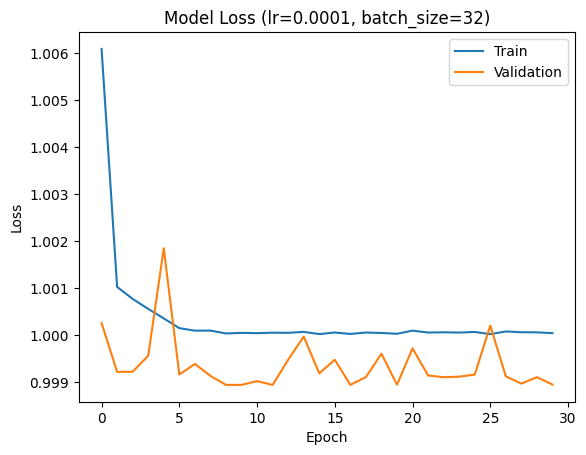

Training model with learning rate=0.0001 and batch size=64
Epoch 1/30
15014/15014 [==============================] - 19s 1ms/step - loss: 1.0015 - mean_absolute_error: 0.6733 - val_loss: 1.0007 - val_mean_absolute_error: 0.6627
Epoch 2/30
15014/15014 [==============================] - 21s 1ms/step - loss: 1.0009 - mean_absolute_error: 0.6730 - val_loss: 1.0007 - val_mean_absolute_error: 0.6628
Epoch 3/30
15014/15014 [==============================] - 18s 1ms/step - loss: 1.0005 - mean_absolute_error: 0.6728 - val_loss: 1.0001 - val_mean_absolute_error: 0.6823
Epoch 4/30
15014/15014 [==============================] - 17s 1ms/step - loss: 1.0005 - mean_absolute_error: 0.6728 - val_loss: 0.9992 - val_mean_absolute_error: 0.6775
Epoch 5/30
15014/15014 [==============================] - 20s 1ms/step - loss: 1.0004 - mean_absolute_error: 0.6727 - val_loss: 1.0009 - val_mean_absolute_error: 0.6853
Epoch 6/30
15014/15014 [==============================] - 22s 1ms/step - loss: 1.0002 - mean_abs

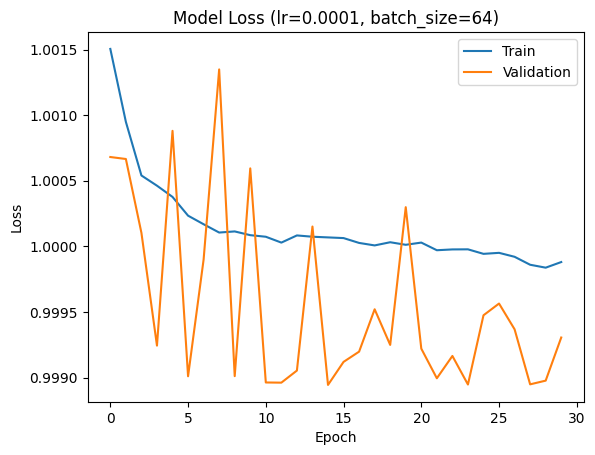

Training model with learning rate=0.001 and batch size=32
Epoch 1/30
30028/30028 [==============================] - 38s 1ms/step - loss: 1.0037 - mean_absolute_error: 0.6744 - val_loss: 1.0009 - val_mean_absolute_error: 0.6852
Epoch 2/30
30028/30028 [==============================] - 32s 1ms/step - loss: 1.0025 - mean_absolute_error: 0.6738 - val_loss: 1.0001 - val_mean_absolute_error: 0.6823
Epoch 3/30
30028/30028 [==============================] - 33s 1ms/step - loss: 1.0024 - mean_absolute_error: 0.6737 - val_loss: 1.0001 - val_mean_absolute_error: 0.6644
Epoch 4/30
30028/30028 [==============================] - 34s 1ms/step - loss: 1.0024 - mean_absolute_error: 0.6737 - val_loss: 0.9993 - val_mean_absolute_error: 0.6683
Epoch 5/30
30028/30028 [==============================] - 33s 1ms/step - loss: 1.0023 - mean_absolute_error: 0.6737 - val_loss: 1.0010 - val_mean_absolute_error: 0.6618
Epoch 6/30
30028/30028 [==============================] - 32s 1ms/step - loss: 1.0026 - mean_abso

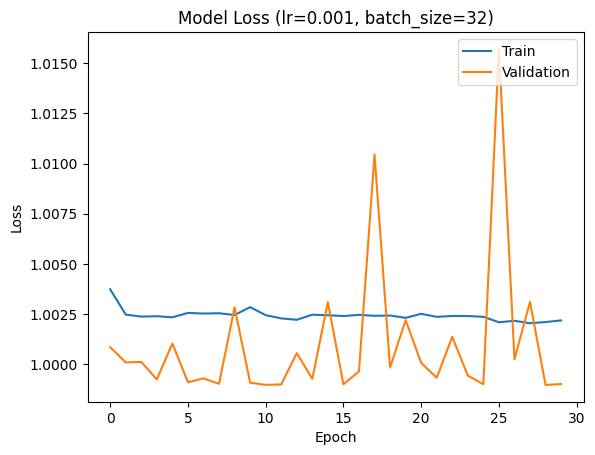

Training model with learning rate=0.001 and batch size=64
Epoch 1/30
15014/15014 [==============================] - 19s 1ms/step - loss: 1.0037 - mean_absolute_error: 0.6743 - val_loss: 0.9994 - val_mean_absolute_error: 0.6674
Epoch 2/30
15014/15014 [==============================] - 20s 1ms/step - loss: 1.0024 - mean_absolute_error: 0.6737 - val_loss: 0.9992 - val_mean_absolute_error: 0.6684
Epoch 3/30
15014/15014 [==============================] - 15s 987us/step - loss: 1.0026 - mean_absolute_error: 0.6738 - val_loss: 0.9990 - val_mean_absolute_error: 0.6713
Epoch 4/30
15014/15014 [==============================] - 20s 1ms/step - loss: 1.0024 - mean_absolute_error: 0.6738 - val_loss: 1.0204 - val_mean_absolute_error: 0.7212
Epoch 5/30
15014/15014 [==============================] - 24s 2ms/step - loss: 1.0024 - mean_absolute_error: 0.6738 - val_loss: 0.9992 - val_mean_absolute_error: 0.6686
Epoch 6/30
15014/15014 [==============================] - 23s 2ms/step - loss: 1.0022 - mean_ab

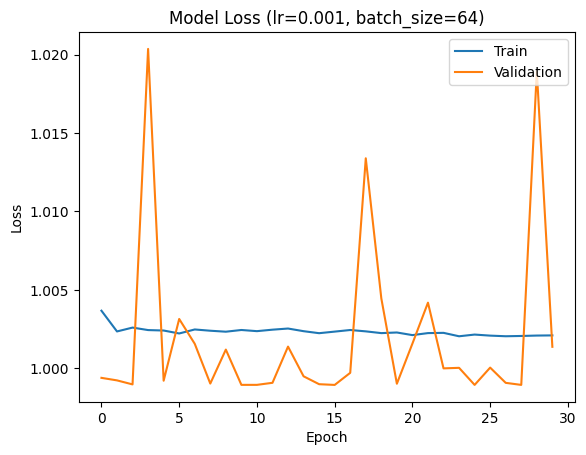

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from sklearn.metrics import r2_score

learning_rates = [1e-5, 1e-4, 0.001]
batch_sizes = [32, 64]

results = {}  # Dictionary to store results for each scenario

for lr in learning_rates:
    for batch_size in batch_sizes:
        print(f"Training model with learning rate={lr} and batch size={batch_size}")
        
        # Define the neural network architecture
        model = Sequential([
            Dense(32, input_shape=(X_selectfit_train.shape[1],), activation='tanh'),
            Dense(64, activation='tanh'),
            Dense(64, activation='tanh'),
            Dense(1)
        ])
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        # Compile the model
        model.compile(optimizer=optimizer,
                      loss='mean_squared_error',
                      metrics=['mean_absolute_error'])
        
        # Train the model
        history = model.fit(X_selectfit_train, y_selectfit_train, epochs=30, batch_size=batch_size, validation_split=0.2, verbose=1)
        
        # Evaluate the model on test data
        print("Evaluate on test data")
        results_lr_batch = model.evaluate(X_selectfit_test, y_selectfit_test)
        print("Test loss, Test acc:", results_lr_batch)
        
        # Making predictions
        predictions = model.predict(X_selectfit_test)
        r2 = r2_score(y_selectfit_test, predictions)
        print("Predictions shape:", predictions.shape)
        print("R^2 Score:", r2)
        
        # Get the first 5 predicted values
        predicted_values = predictions[:5]
        print("First 5 Predicted Values:", predicted_values)
       
        # Store results for this scenario
        results[(lr, batch_size)] = {
            'loss': results_lr_batch[0],
            'mae': results_lr_batch[1],
            'predictions': predictions,
            'r2': r2
        }
        
        # Plot the loss values over epochs
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title(f'Model Loss (lr={lr}, batch_size={batch_size})')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.show()

## 4.4 Training with Location Factors

In [104]:
from sklearn.cluster import DBSCAN, AgglomerativeClustering

In [105]:
df_school = pd.read_csv('school_std.csv')
df_subway = pd.read_csv('subway_std.csv')

### 4.4.1 Mapping Methods

In [106]:
#DB scan for small area

df_geog = pd.concat([price_std[['latitude', 'longitude', 'address_by_law']],
                     df_school[['latitude', 'longitude', 'address_by_law']],
                     df_subway[['latitude', 'longitude', 'address_by_law']]], axis=0, ignore_index=True)

#db scan and append to the df_geog
#1 degree of lat and long ~111km

df_geog['latitude_scaled'] = df_geog['latitude'] * 111000
df_geog['longitude_scaled'] = df_geog['longitude'] * 111000 * np.cos(np.radians(df_geog['latitude']))


df_geog_unique = df_geog.drop_duplicates(subset=['latitude_scaled', 'longitude_scaled'])

In [99]:
unique_addresses = price_std['address_by_law'].nunique()

# Print the result
print(f"Number of unique addresses by law: {unique_addresses}")

Number of unique addresses by law: 377


### 44.2 Mapping by Distance using DBScan

In [107]:
from math import radians

# Convert latitude and longitude from degrees to radians
coords = df_geog_unique[['latitude', 'longitude']]
coords_rad = np.radians(coords)

# Use DBSCAN with a metric of 'haversine'
db = DBSCAN(eps=400/6371000,  # 400 meters, converted to radians given Earth's radius in meters
            min_samples=5,
            metric='haversine')
clusters = db.fit_predict(coords_rad)

# Add the cluster labels to your original dataframe
df_geog_unique['cluster'] = clusters

# Output the results
unique_cluster = df_geog_unique['cluster'].nunique()
print(f"Number of unique lat & long: {len(df_geog_unique)}")
print(f"Number of unique clusters: {unique_cluster}")

# Using value_counts to count occurrences of each cluster
cluster_counts = df_geog_unique['cluster'].value_counts()

# Print the count of cluster -1 (noise points)
print("Count of 'cluster' = -1:", cluster_counts.get(-1, 0))

# Print cluster counts
print("\nCluster counts:")
print(cluster_counts)

Number of unique lat & long: 6232
Number of unique clusters: 128
Count of 'cluster' = -1: 551

Cluster counts:
cluster
 48     667
 10     592
-1      551
 34     437
 1      271
       ... 
 118      4
 125      4
 69       4
 121      4
 90       3
Name: count, Length: 128, dtype: int64


In [108]:
unique_addresses = df_geog['address_by_law'].nunique()

# Print the result
print(f"Number of long lat pairs: {len(df_geog)}")
print(f"Number of unique long lat pairs: {len(df_geog_unique)}")
print(f"Number of unique addresses by law: {unique_addresses}")

Number of long lat pairs: 1603784
Number of unique long lat pairs: 6232
Number of unique addresses by law: 698


In [109]:
X = price_std.drop(['transaction_real_price'], axis=1)

X_c = pd.merge(X, df_geog_unique[['latitude', 'longitude', 'cluster']],
                      on=['latitude', 'longitude'],
                      how='left')

In [110]:
#merge cluster into subway and school

school_c = pd.merge(df_school, df_geog_unique[['latitude', 'longitude', 'cluster']],
                      on=['latitude', 'longitude'],
                      how='left')

subway_c = pd.merge(df_subway, df_geog_unique[['latitude', 'longitude', 'cluster']],
                      on=['latitude', 'longitude'],
                      how='left')

In [111]:
# Group by 'cluster' in 'subway_c' and count the number of rows for each cluster
subway_c = subway_c[subway_c['cluster'] != -1]
subway_clusters = subway_c.groupby('cluster').size()
print("Number of rows per cluster in 'subway_c':")
print(subway_clusters)
print(len(subway_c))

# Group by 'cluster' in 'school_c' and count the number of rows for each cluster
school_c = school_c[school_c['cluster'] != -1]
school_clusters = school_c.groupby('cluster').size()
print("\nNumber of rows per cluster in 'school_c':")
print(school_clusters)
print(len(school_c))

Number of rows per cluster in 'subway_c':
cluster
0       1
1      18
2      14
3       2
4       2
       ..
115     1
122     1
123     1
125     1
126     1
Length: 79, dtype: int64
322

Number of rows per cluster in 'school_c':
cluster
0      10
1      89
2      54
3      11
4      10
       ..
122     1
123     2
124     4
125     2
126     3
Length: 125, dtype: int64
1679


In [112]:
school_c.head()

school_code  latitude  longitude  address_by_law  foundation_year  city  \
0            0  0.618471  -0.750931      1165010800             1953     1   
2            2  0.611371  -0.707439      1168010300             1982     1   
3            3  0.614638  -0.708481      1168010300             1987     1   
4            4  0.610953  -0.714525      1168010300             1983     1   
6            6  0.621096  -0.701397      1168010600             1981     1   

   school_class_middle  school_class_elementary  school_class_high  \
0                    0                        1                  0   
2                    0                        1                  0   
3                    0                        1                  0   
4                    0                        1                  0   
6                    0                        1                  0   

   operation_type_private  operation_type_public  operation_type_national  \
0                       0                      0                        1   
2                       0                      1                        0   
3                       0                      1                        0   
4                       0                      1                        0   
6                       0                      1                        0   

   highschool_type_-  highschool_type_specialized  highschool_type_general  \
0                  1                            0                        0   
2                  1                            0                        0   
3                  1                            0                        0   
4                  1                            0                        0   
6                  1                            0                        0   

   highschool_type_autonomous  highschool_type_objective  gender_male  \
0                           0                          0            0   
2                           0                          0            0   
3                           0                          0            0   
4                           0                          0            0   
6                           0                          0            0   

   gender_both  gender_female  cluster  
0            1              0       34  
2            1              0       34  
3            1              0       34  
4            1              0       34  
6            1              0       34

In [114]:
#Transform and add school feature

school_c_transform = school_c.groupby('cluster').agg({
    'school_class_elementary': 'sum',
    'school_class_high': 'sum',
    'school_class_middle': 'sum',
    'operation_type_public': 'sum',
    'operation_type_national': 'sum',
    'operation_type_private': 'sum',
    'highschool_type_-': 'sum',
    'highschool_type_specialized': 'sum',
    'highschool_type_autonomous': 'sum',
    'highschool_type_objective': 'sum',
    'highschool_type_general': 'sum',
    'gender_male': 'sum',
    'gender_both': 'sum',
    'gender_female': 'sum',
    'foundation_year': 'min'  # This will find the minimum foundation year for each cluster
}).reset_index()


school_c_transform['number_of_schools'] = school_c.groupby('cluster').size().values

school_c_transform.head()

cluster  school_class_elementary  school_class_high  school_class_middle  \
0        0                        2                  5                    3   
1        1                       42                 24                   23   
2        2                       23                 15                   16   
3        3                        6                  1                    4   
4        4                        5                  2                    3   

   operation_type_public  operation_type_national  operation_type_private  \
0                      4                        0                       6   
1                     60                        2                      27   
2                     26                        0                      28   
3                     10                        0                       1   
4                     10                        0                       0   

   highschool_type_-  highschool_type_specialized  highschool_type_autonomous  \
0                  5                            0                           1   
1                 65                            8                           3   
2                 39                            3                           3   
3                 10                            0                           0   
4                  8                            0                           1   

   highschool_type_objective  highschool_type_general  gender_male  \
0                          2                        2            6   
1                          2                       11           12   
2                          1                        8           14   
3                          0                        1            0   
4                          0                        1            0   

   gender_both  gender_female  foundation_year  number_of_schools  
0            4              0             1885                 10  
1           66             11             1895                 89  
2           29             11             1886                 54  
3           11              0             1946                 11  
4           10              0             1979                 10

In [118]:
#Transform subway
#Transform and add school feature

subway_c_transform = subway_c.groupby('cluster').agg({
    'line_9': 'sum',
    'line_AP': 'sum',
    'line_7': 'sum',
    'line_1': 'sum',
    'line_DL': 'sum',
    'line_8': 'sum',
    'line_US': 'sum',
    'line_B3': 'sum',
    'line_5': 'sum',
    'line_BK': 'sum',
    'line_B2': 'sum',
    'line_4': 'sum',
    'line_2': 'sum',
    'line_KJ': 'sum',
    'line_3': 'sum',
    'line_B1': 'sum',
    'line_B4': 'sum',
    'line_BD': 'sum',
    'line_KC': 'sum',
    'line_6': 'sum',
    'line_ND': 'sum'
}).reset_index()


subway_c_transform['number_of_lines'] = subway_c_transform.groupby('cluster').size().values

subway_c_transform.head()

cluster  line_9  line_AP  line_7  line_1  line_DL  line_8  line_US  \
0        0       0        0       0       0        0       0        0   
1        1       0        0       0       1        0       0        2   
2        2       0        1       0       0        0       0        0   
3        3       0        0       0       0        0       0        0   
4        4       0        0       2       0        0       0        0   

   line_B3  line_5  line_BK  line_B2  line_4  line_2  line_KJ  line_3  \
0        0       0        0        0       1       0        0       0   
1        0       3        0        0       4       2        2       3   
2        0       5        0        0       0       3        4       1   
3        0       1        0        0       0       1        0       0   
4        0       0        0        0       0       1        0       0   

   line_B1  line_B4  line_BD  line_KC  line_6  line_ND  number_of_lines  
0        0        0        0        0       0        0                1  
1        0        0        0        0       8        0                1  
2        0        0        0        0       5        0                1  
3        0        0        0        0       0        0                1  
4        0        0        0        0       0        0                1

In [119]:
X_cs = pd.merge(X_c, school_c_transform,
                      on=['cluster'],
                      how='left')

X_cs = pd.merge(X_cs, subway_c_transform,
                      on=['cluster'],
                      how='left')

In [136]:
#all together x_cs

'''
location_features = ['apartment_id', 'latitude', 'longitude', 'address_by_law', 'room_id', 'transaction_year', 'building_age', 'cluster']
dwelling_features = ['exclusive_use_area', 'total_household_count_in_sites', 'total_parking_capacity_in_site',
                     'apartment_building_count_in_sites', 'tallest_building_in_sites',  
                    'lowest_building_in_sites', 'supply_area', 'total_household_count_of_area_type',
                     'diff_height_in_site','heat_fuel_cogeneration','heat_type_individual' ]
schsub_features = ['line__2', 'line__5', 'line__DL',  'line__1', 'school_class_middle', 'foundation_year', 'operation_type_public',
                         'line__KJ', 'gender_male', 'operation_type_private', 'number_of_schools']

lds_features = location_features + dwelling_features + schsub_features
'''

X_og = X_cs
y = price_std['transaction_real_price']


X_train_og, X_test_og, y_train_og, y_test_og = train_test_split(X_og, y, random_state=2024)

In [144]:
def model_test_score(model,X_train,y_train,X_test,y_test):
    score = model.score(X_train, y_train)
    print("Training score: ", score)

    test_pred = model.predict(X_test)
    test_score_mae = mean_absolute_error(y_test, test_pred)
    print("Test MAE score:", test_score_mae)

    test_score_mse = mean_squared_error(y_test, test_pred, squared=False)
    print("Test MSE score:", test_score_mse)

    test_score_r2 = r2_score(y_test, test_pred)
    print("Test R2 score:", test_score_r2)

In [145]:
#Tree gen

tree_regressor_15 = DecisionTreeRegressor(max_depth=15, random_state=2024)
tree_regressor_15.fit(X_train_og, y_train_og)
model_test_score(tree_regressor_15, X_train_og, y_train_og, X_train_og, y_train_og)

features_importances = sorted(zip(X_train_og.columns, tree_regressor_15.feature_importances_), key=lambda x: x[1], reverse=True)
# Print feature importance for the original data
print("Feature importances for model trained on original data:")
for feature, importance in features_importances:
    print(f"{feature}: {importance:.4f}")

Training score:  0.9759497505744543
Test MAE score: 30231605.575630546
Test MSE score: 49984004.56468855
Test R2 score: 0.9759497505744543
Feature importances for model trained on original data:
supply_area: 0.2920
latitude: 0.1595
heat_fuel_cogeneration: 0.1151
exclusive_use_area: 0.0735
transaction_year: 0.0604
line_DL: 0.0599
address_by_law: 0.0484
longitude: 0.0411
apartment_building_count_in_sites: 0.0316
line_9: 0.0169
apartment_id: 0.0159
tallest_building_in_sites: 0.0134
building_age: 0.0086
total_parking_capacity_in_site: 0.0084
excl_use_area_ratio: 0.0079
foundation_year: 0.0051
room_id: 0.0046
total_household_count_in_sites: 0.0039
highschool_type_-: 0.0038
lowest_building_in_sites: 0.0032
transaction_month: 0.0024
total_household_count_of_area_type: 0.0020
line_5: 0.0019
diff_height_in_site: 0.0016
line_B1: 0.0015
floor: 0.0015
heat_type_district: 0.0013
line_3: 0.0013
gender_both: 0.0010
cluster: 0.0010
bathroom_count: 0.0010
front_door_structure_-: 0.0010
school_class_hig

In [146]:
ran_forest_max = RandomForestRegressor(max_depth=None, random_state=2024, n_estimators=10)
ran_forest_max.fit(X_train_og, y_train_og)
model_test_score(ran_forest_max, X_train_og, y_train_og, X_test_og, y_test_og)

Training score:  0.9979018833654644
Test MAE score: 15983374.657549847
Test MSE score: 34963047.95849546
Test R2 score: 0.9882554349371007


In [160]:
###Link attributes by address by law and do another test


school_a_transform = school_c.groupby('address_by_law').agg({
    'school_class_elementary': 'sum',
    'school_class_high': 'sum',
    'school_class_middle': 'sum',
    'operation_type_public': 'sum',
    'operation_type_national': 'sum',
    'operation_type_private': 'sum',
    'highschool_type_-': 'sum',
    'highschool_type_specialized': 'sum',
    'highschool_type_autonomous': 'sum',
    'highschool_type_objective': 'sum',
    'highschool_type_general': 'sum',
    'gender_male': 'sum',
    'gender_both': 'sum',
    'gender_female': 'sum',
    'foundation_year': 'min'  # This will find the minimum foundation year for each cluster
}).reset_index()


school_a_transform['number_of_schools'] = school_c.groupby('address_by_law').size().values


subway_a_transform = subway_c.groupby('address_by_law').agg({
    'line_9': 'sum',
    'line_AP': 'sum',
    'line_7': 'sum',
    'line_1': 'sum',
    'line_DL': 'sum',
    'line_8': 'sum',
    'line_US': 'sum',
    'line_B3': 'sum',
    'line_5': 'sum',
    'line_BK': 'sum',
    'line_B2': 'sum',
    'line_4': 'sum',
    'line_2': 'sum',
    'line_KJ': 'sum',
    'line_3': 'sum',
    'line_B1': 'sum',
    'line_B4': 'sum',
    'line_BD': 'sum',
    'line_KC': 'sum',
    'line_6': 'sum',
    'line_ND': 'sum'
}).reset_index()

subway_a_transform = subway_a_transform[subway_a_transform['address_by_law'] != '-']
subway_a_transform['address_by_law'] = pd.to_numeric(subway_a_transform['address_by_law'])

subway_a_transform['number_of_lines'] = subway_a_transform.groupby('address_by_law').size().values


X_ca = pd.merge(X_c, school_a_transform,
                      on=['address_by_law'],
                      how='left')

X_ca = pd.merge(X_ca, subway_a_transform,
                      on=['address_by_law'],
                      how='left')


#Fill NA in X_cs

X_ca.fillna(0, inplace=True)

In [170]:
#x_cs, but dropping 0.00 importance features


X_og = X_cs


# Columns you want to drop from X_og
columns_to_drop = [
    'line_KC', 'transaction_date_11~20', 'line_8', 
    'highschool_type_autonomous', 'line_US', 
    'heat_fuel_-', 'city', 'line_B1', 'line_B4', 
    'line_B3', 'line_6', 'operation_type_national', 'heat_type_-', 
    'line_BK', 'highschool_type_-', 'line_AP'
]

# Drop the columns
X_og = X_og.drop(columns=columns_to_drop)


X_train_og, X_test_og, y_train_og, y_test_og = train_test_split(X_og, y, random_state=2024)



#Tree gen

ran_forest_max = RandomForestRegressor(max_depth=None, random_state=2024, n_estimators=10)
ran_forest_max.fit(X_train_og, y_train_og)
model_test_score(ran_forest_max,X_train_og, y_train_og,X_test_og,y_test_og)



Training score:  0.9979197418375525
Test MAE score: 15943601.228018649
Test MSE score: 34894446.90001677
Test R2 score: 0.9883014777862911


In [173]:
#x_cs, but dropping 0.001 importance features


X_og = X_cs


# Columns you want to drop from X_og
columns_to_drop = [
    'line_KC', 'line_8', 'highschool_type_autonomous', 'line_US', 
    'heat_fuel_-', 'city', 'line_B1', 'line_B4', 'line_B3', 
    'line_6', 'operation_type_national', 'heat_type_-', 
    'line_BK', 'highschool_type_-', 'line_AP'
]

additional_columns_to_drop = [
    'line_1', 'line_KJ', 'front_door_structure_-', 'room_count',
    'operation_type_private', 'line_5', 'heat_fuel_gas', 'heat_type_district',
    'school_class_middle', 'line_2', 'front_door_structure_stairway', 'line_ND',
    'line_7', 'line_4', 'school_class_high', 'number_of_lines',
    'front_door_structure_mixed', 'line_B2', 'heat_type_central',
    'highschool_type_specialized', 'gender_both', 'line_BD',
    'gender_female', 'transaction_date_1~10',
    'highschool_type_general'
]

final_columns_to_drop = columns_to_drop + additional_columns_to_drop


# Drop the columns
X_og = X_og.drop(columns=final_columns_to_drop)


X_train_og, X_test_og, y_train_og, y_test_og = train_test_split(X_og, y, random_state=2024)



#Tree gen

ran_forest_max = RandomForestRegressor(max_depth=None, random_state=2024, n_estimators=10)
ran_forest_max.fit(X_train_og, y_train_og)
model_test_score(ran_forest_max,X_train_og, y_train_og,X_test_og,y_test_og)



Training score:  0.9979086598218039
Test MAE score: 15956651.079331137
Test MSE score: 35055216.77655974
Test R2 score: 0.9881934317907886


In [174]:
features_importances = sorted(zip(X_train_og.columns, ran_forest_max.feature_importances_), key=lambda x: x[1], reverse=True)
# Print feature importance for the original data
print("Feature importances for model trained on original data:")
for feature, importance in features_importances:
    print(f"{feature}: {importance:.4f}")

Feature importances for model trained on original data:
supply_area: 0.2864
latitude: 0.1511
heat_fuel_cogeneration: 0.1022
exclusive_use_area: 0.0754
address_by_law: 0.0700
transaction_year: 0.0627
line_DL: 0.0525
longitude: 0.0427
apartment_building_count_in_sites: 0.0252
apartment_id: 0.0165
line_9: 0.0156
tallest_building_in_sites: 0.0148
building_age: 0.0119
total_parking_capacity_in_site: 0.0101
room_id: 0.0075
excl_use_area_ratio: 0.0073
transaction_month: 0.0057
lowest_building_in_sites: 0.0055
floor: 0.0054
school_class_elementary: 0.0053
total_household_count_in_sites: 0.0050
foundation_year: 0.0038
total_household_count_of_area_type: 0.0026
diff_height_in_site: 0.0024
line_3: 0.0019
cluster: 0.0018
bathroom_count: 0.0017
operation_type_public: 0.0016
front_door_structure_corridor: 0.0016
number_of_schools: 0.0009
gender_male: 0.0008
highschool_type_objective: 0.0006
heat_type_individual: 0.0006
transaction_date_21~31: 0.0005
transaction_date_11~20: 0.0005


In [175]:
X_ca = pd.merge(X_c, school_a_transform,
                      on=['address_by_law'],
                      how='left')

X_ca = pd.merge(X_ca, subway_a_transform,
                      on=['address_by_law'],
                      how='left')


#Fill NA in X_cs

X_ca.fillna(0, inplace=True)

In [176]:
#####################investigate top 10

X_cat = X_ca
X_cat['transaction_real_price'] = y


# Calculate the mean transaction price for each unique address_by_law
med_prices = X_cat.groupby('address_by_law')['transaction_real_price'].median()

# Sort the mean prices in descending order and select the top 10
top_10_addresses = med_prices.sort_values(ascending=False).head(10)

# Print the top 10 addresses and their mean prices
for address, med_price in top_10_addresses.items():
    print(f"Address: {address}, Median Transaction Price: {med_price}")

Address: 1117012700, Median Transaction Price: 1550000000.0
Address: 1168011000, Median Transaction Price: 1510000000.0
Address: 1114012200, Median Transaction Price: 1435000000.0
Address: 1117011600, Median Transaction Price: 1400000000.0
Address: 1117012800, Median Transaction Price: 1250000000.0
Address: 1165010700, Median Transaction Price: 1250000000.0
Address: 1111017700, Median Transaction Price: 1240000000.0
Address: 1168010600, Median Transaction Price: 1200000000.0
Address: 1117013300, Median Transaction Price: 1185000000.0
Address: 1144012200, Median Transaction Price: 1185000000.0


In [177]:
#Now select top 100 and bottom 100 for visulization

# Calculate the medium transaction price for each unique address_by_law
med_prices = X_cat.groupby('address_by_law')['transaction_real_price'].median()

# Sort the medium prices in descending order and select the top 100
top_100_addresses = med_prices.sort_values(ascending=False).head(100)



columns_to_print  = ['address_by_law'] + list(X_cat.columns[1:4]) + list(X_cat.columns[7:12]) + list(X_cat.columns[13:21]) + list(X_cat.columns[27:77])   # Columns 'cluster' to 'number_of_lines'
selected_df_top100 = X_cat.reset_index().loc[X_cat['address_by_law'].isin(top_100_addresses.index), columns_to_print].drop_duplicates(subset='address_by_law')



# Calculate the medium transaction price for each unique address_by_law
med_prices = X_cat.groupby('address_by_law')['transaction_real_price'].median()

# Sort the medium prices in descending order and select the bot 100
bot_100_addresses = med_prices.sort_values(ascending=True).head(100)



columns_to_print  = ['address_by_law'] + list(X_cat.columns[1:4]) + list(X_cat.columns[7:12]) + list(X_cat.columns[13:21]) + list(X_cat.columns[27:77])   # Columns 'cluster' to 'number_of_lines'
selected_df_bot100 = X_cat.reset_index().loc[X_cat['address_by_law'].isin(bot_100_addresses.index), columns_to_print].drop_duplicates(subset='address_by_law')



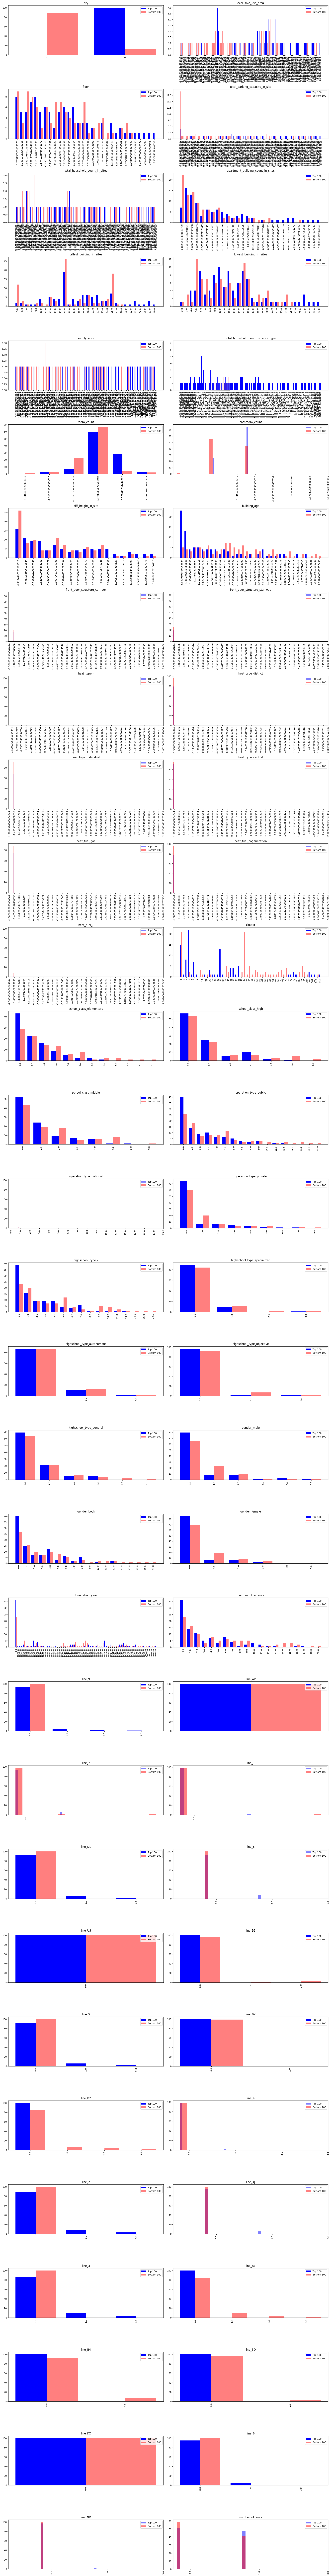

In [180]:
selected_columns = ['city', 'exclusive_use_area', 'floor', 'total_parking_capacity_in_site', 'total_household_count_in_sites',
'apartment_building_count_in_sites', 'tallest_building_in_sites', 'lowest_building_in_sites', 'supply_area',
'total_household_count_of_area_type', 'room_count', 'bathroom_count', 'diff_height_in_site', 'building_age',
'front_door_structure_corridor', 'front_door_structure_stairway',
'heat_type_-', 'heat_type_district', 'heat_type_individual', 'heat_type_central', 'heat_fuel_gas',
'heat_fuel_cogeneration', 'heat_fuel_-', 'cluster', 'school_class_elementary', 'school_class_high',
'school_class_middle', 'operation_type_public', 'operation_type_national', 'operation_type_private',
'highschool_type_-', 'highschool_type_specialized', 'highschool_type_autonomous', 'highschool_type_objective',
'highschool_type_general', 'gender_male', 'gender_both', 'gender_female', 'foundation_year', 'number_of_schools',
'line_9', 'line_AP', 'line_7', 'line_1', 'line_DL', 'line_8', 'line_US', 'line_B3', 'line_5',
'line_BK', 'line_B2', 'line_4', 'line_2', 'line_KJ', 'line_3', 'line_B1', 'line_B4', 'line_BD',
'line_KC', 'line_6', 'line_ND', 'number_of_lines']

selected_df_top100 = selected_df_top100[selected_columns]
selected_df_bot100 = selected_df_bot100[selected_columns]

num_cols = 2
num_rows = (len(selected_columns) + num_cols - 1) // num_cols  # This ensures all columns are included

# Create a figure with multiple subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, num_rows * 5))  # Adjusting figure size dynamically
fig.subplots_adjust(hspace=0.5, wspace=0.3)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate over selected columns for plotting
for i, col in enumerate(selected_columns):
    if selected_df_top100[col].nunique() == 2:
        # Binary column, use histograms
        axes[i].hist(selected_df_top100[col], bins=20, alpha=0.5, color='blue', label='Top 100')
        axes[i].hist(selected_df_bot100[col], bins=20, alpha=0.5, color='red', label='Bottom 100')
    else:
        # Non-binary column, use bar plots
        top100_counts = selected_df_top100[col].value_counts()
        bot100_counts = selected_df_bot100[col].value_counts()
        all_values = sorted(list(set(top100_counts.index) | set(bot100_counts.index)))
        x = range(len(all_values))
        
        top100_counts = top100_counts.reindex(all_values).fillna(0)
        bot100_counts = bot100_counts.reindex(all_values).fillna(0)
        
        axes[i].bar(x, top100_counts, width=0.4, color='blue', label='Top 100')
        axes[i].bar([pos + 0.4 for pos in x], bot100_counts, width=0.4, color='red', label='Bottom 100', alpha=0.5)

    axes[i].set_title(col)
    axes[i].set_xticks([pos + 0.2 for pos in x])
    axes[i].set_xticklabels(all_values, rotation=90)
    axes[i].legend()

# Hide any unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### 4.4.4 Analysis on Location Identifier

In [246]:
def extract_cluster_feature(df, features):
    kmeans = KMeans()
    kmeans.fit(df[features])
    df['cluster'] = kmeans.labels_

In [284]:
X_seoul = X_all[X_all['city'] == 0]
y_seoul = y_all[X_all['city'] == 0]
X_busan = X_all[X_all['city'] == 1]
y_busan = y_all[X_all['city'] == 1]

In [315]:
FLAT_FEATURES = [
    'exclusive_use_area', 
    'city', 
    'total_parking_capacity_in_site', 
    'transaction_year', 
    'tallest_building_in_sites',
     # compare with other location feature
    'address_by_law'
]

**Seoul**

**Subway**

In [286]:
extract_cluster_feature(X_seoul, ['latitude',  'longitude'])

In [287]:
df_subway_seoul = df_subway[df_subway['city'] == 0]

In [288]:
RANGE = max(df_subway_seoul['latitude']) - min(df_subway_seoul['latitude']) + max(df_subway_seoul['longitude']) - min(df_subway_seoul['longitude'])
RANGE = RANGE * 0.1 # 1/10 of all distance
RANGE

0.0467287919455534

(array([ 46801.,  25241., 142449., 121095.,  65952.,  55176.,  79771.,
         43419.,  18604.,   1578.]),
 array([ 0.,  4.,  8., 12., 16., 20., 24., 28., 32., 36., 40.]),
 <BarContainer object of 10 artists>)

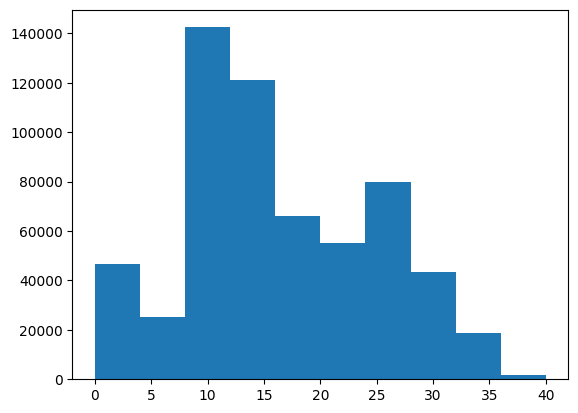

In [289]:
# find feature importance via Decision Tree regressor
A = X_seoul[['longitude', 'latitude']].to_numpy()
B = df_subway_seoul[['longitude', 'latitude']].to_numpy()

# Calculate the Manhattan distance between each element of A and B
manhattan_dist = np.abs(A[:, np.newaxis, :] - B).sum(axis=2)
in_range = manhattan_dist < RANGE
subway_cnt = np.sum(in_range, axis=1)

X_seoul['subway_count'] = subway_cnt

plt.hist(subway_cnt)

In [290]:
def filter_subway(df):
    remove_columns = [_ for _ in df.columns if (df[_] == 0).all()]
    df.drop(remove_columns, axis=1, inplace=True)

In [291]:
filter_subway(df_subway_seoul)

In [292]:
df_subway_seoul.head()

station_id  latitude  longitude address_by_law  line_B1  line_B2  \
278         593 -1.169348   1.173347   2638010400.0        1        0   
279         594 -1.161145   1.179269   2638010300.0        1        0   
280         595 -1.163116   1.186224   2638010200.0        1        0   
281         596 -1.165933   1.195684   2638010100.0        1        0   
282         597 -1.165842   1.204872   2638010100.0        1        0   

     line_B3  line_B4  line_BD  line_BK  
278        0        0        0        0  
279        0        0        0        0  
280        0        0        0        0  
281        0        0        0        0  
282        0        0        0        0

In [293]:
SUBWAY_LINE_SEOUL = ['line_B3', 'line_B4', 'line_B2', 'line_BD', 'line_BK', 'line_B1']

lines = df_subway_seoul[SUBWAY_LINE_SEOUL].to_numpy()
distinct_line = np.count_nonzero(in_range @ lines, axis=1)

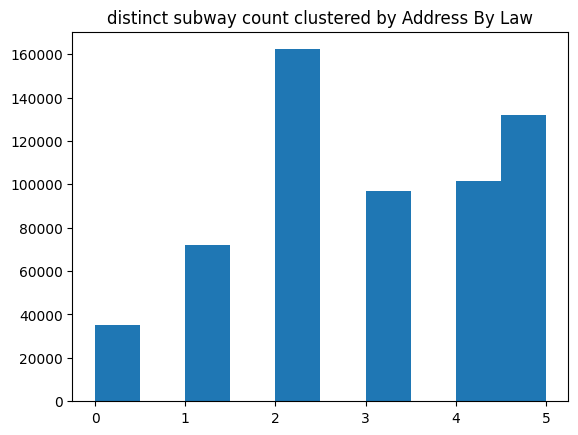

In [294]:
plt.hist(distinct_line)
plt.title("distinct subway count clustered by Address By Law")
plt.show()

In [295]:
has_line = distinct_line > 0

X_seoul['distinct_line_dist'] = distinct_line
X_seoul['has_subway_dist'] = has_line

In [296]:
df_school_seoul = df_school[df_school['city'] == 0]

In [297]:
RANGE_SCHOOL = max(df_school_seoul['latitude']) - min(df_school_seoul['latitude']) + max(df_school_seoul['longitude']) - min(df_school_seoul['longitude'])
RANGE_SCHOOL = RANGE_SCHOOL * 0.01 # 1 / 100 of all school distance
RANGE_SCHOOL

0.0067905920504671745

(array([6.30210e+04, 9.97030e+04, 1.44887e+05, 1.87849e+05, 6.43670e+04,
        2.22980e+04, 1.43150e+04, 3.47900e+03, 1.64000e+02, 3.00000e+00]),
 array([ 0. ,  1.3,  2.6,  3.9,  5.2,  6.5,  7.8,  9.1, 10.4, 11.7, 13. ]),
 <BarContainer object of 10 artists>)

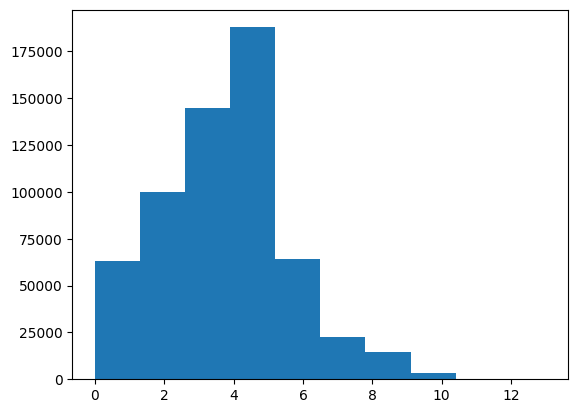

In [298]:
A = X_seoul[['longitude', 'latitude']].to_numpy()
C = df_school_seoul[['longitude', 'latitude']].to_numpy()

manhattan_dist_school = np.abs(A[:, np.newaxis, :] - C).sum(axis=2)
in_range_school = manhattan_dist_school < RANGE_SCHOOL
school_cnt = np.sum(in_range_school, axis=1)

X_seoul['school_count_dist'] = school_cnt

plt.hist(school_cnt)

Cluster by address_by_law

In [299]:
# Step 1: Create a new DataFrame with unique addresses
df_school_seoul_transform = pd.DataFrame(df_school_seoul['address_by_law'].unique(), columns=['address_by_law'])

# Step 2: Perform the groupby operation and sum, then reset index to flatten the DataFrame
df_school_seoul_counts = df_school_seoul['address_by_law'].value_counts()
df_school_seoul_transform['number_of_school_addr'] = df_school_seoul_transform['address_by_law'].map(df_school_seoul_counts)


# Step 3: Compute the average of 'foundation_year' by 'address_by_law'
average_foundation_year = df_school_seoul.groupby('address_by_law')['foundation_year'].mean().reset_index()
average_foundation_year.rename(columns={'foundation_year': 'average_foundation_year'}, inplace=True)

# Merge the summed columns and the averaged column into df_school_seoul_transform
df_school_seoul_transform = df_school_seoul_transform.merge(average_foundation_year, on='address_by_law', how='left')

# Now sch_df_transform contains the unique address_by_law, summed and averaged columns as specified.

In [300]:
df_school_seoul_transform.head()

address_by_law  number_of_school_addr  average_foundation_year
0      2647010100                     11                   1972.0
1      2641010900                     15                   1972.4
2      2626010100                     15                   1975.2
3      2626010700                      5                   1958.6
4      2626010800                     10                   1971.8

In [301]:
df_subway_seoul = df_subway[df_subway['city'] == 0]

# Step 1: Create a new DataFrame with unique addresses
df_subway_seoul_transform = pd.DataFrame(df_subway_seoul['address_by_law'].unique(), columns=['address_by_law'])

# Step 2: Perform the groupby operation and sum, then reset index to flatten the DataFrame
df_subway_seoul_counts = df_subway_seoul['address_by_law'].value_counts()
df_subway_seoul_transform['number_of_subway_addr'] = df_subway_seoul_transform['address_by_law'].map(df_subway_seoul_counts)
df_subway_seoul_transform = df_subway_seoul_transform[df_subway_seoul_transform['address_by_law'] != '-']
df_subway_seoul_transform['address_by_law'] = pd.to_numeric(df_subway_seoul_transform['address_by_law'])

In [302]:
#drop the column of previous method
drop_feature = ['cluster', 'subway_count', 'distinct_line', 'has_subway', 'school_count']
# X_seoul_second = X_seoul.drop(drop_feature, axis=1)
X_seoul_second = X_seoul.copy()
X_seoul_second = pd.merge(X_seoul_second, df_school_seoul_transform, on='address_by_law', how='left')
X_seoul_second = pd.merge(X_seoul_second, df_subway_seoul_transform, on='address_by_law', how='left')
X_seoul_second = X_seoul_second.fillna(0)

X_seoul_second.head()

city  exclusive_use_area     floor  latitude  longitude  address_by_law  \
0     0            0.196117 -0.852127 -1.152681   1.223180      2614010600   
1     0            1.115385  0.120889 -1.151880   1.223050      2614010600   
2     0           -1.101359  0.120889 -1.179418   1.231544      2614012400   
3     0           -0.504584 -0.852127 -1.177814   1.282234      2620012100   
4     0           -1.054574 -1.269134 -1.176829   1.277556      2620012100   

   total_parking_capacity_in_site  total_household_count_in_sites  \
0                       -0.546816                       -0.547497   
1                       -0.595315                       -0.820525   
2                       -0.742160                       -0.785953   
3                       -0.857346                       -0.919807   
4                        0.097818                        2.547994   

   apartment_building_count_in_sites  tallest_building_in_sites  \
0                          -0.768127                       23.0   
1                          -0.696655                       21.0   
2                          -0.839598                       20.0   
3                          -0.696655                        6.0   
4                           0.947192                       15.0   

   lowest_building_in_sites  supply_area  total_household_count_of_area_type  \
0                      18.0     0.188941                           -0.201291   
1                      18.0     2.239425                           -0.667647   
2                       9.0    -1.112613                           -0.664559   
3                       6.0    -0.709413                           -0.868397   
4                      15.0    -1.006444                            2.152107   

   room_count  bathroom_count  transaction_year  transaction_month  \
0    0.074859        0.813783              2006                  1   
1    1.571822        0.813783              2006                  1   
2    0.074859       -1.154196              2006                  1   
3    0.074859       -1.154196              2006                  1   
4   -1.422105       -1.154196              2006                  1   

   building_age  diff_height_in_site  excl_use_area_ratio  \
0     -0.427518            -0.300707             0.197290   
1     -1.350255            -0.628032            -2.684408   
2     -0.542861             0.681268            -0.527121   
3      0.379876            -1.119020             1.064982   
4     -0.081492            -1.119020            -0.878409   

   transaction_date_21~31  transaction_date_1~10  transaction_date_11~20  \
0                       0                      0                       1   
1                       0                      0                       1   
2                       0                      0                       1   
3                       0                      0                       1   
4                       0                      0                       1   

   front_door_structure_mixed  front_door_structure_-  \
0                           0                       0   
1                           0                       0   
2                           0                       0   
3                           0                       0   
4                           0                       0   

   front_door_structure_stairway  front_door_structure_corridor  \
0                              1                              0   
1                              1                              0   
2                              0                              1   
3                              1                              0   
4                              0                              1   

   heat_type_individual  heat_type_-  heat_type_district  heat_type_central  \
0                     1            0                   0                  0   
1                     1            0                   0                  0   
2      

In [309]:
X_train_seoul, X_test_seoul, y_train_seoul, y_test_seoul = train_test_split(
    X_seoul_second, y_seoul, test_size=0.3, random_state=2024)

In [316]:
# find feature importance via Decision Tree regressor
LOC_FEATURES = ['number_of_school_addr', 'number_of_subway_addr', 'distinct_line_dist', 'has_subway_dist', 'school_count_dist']
dt = DecisionTreeRegressor(random_state=2024)

predict_with_regressor(dt, 
                       X_train_seoul[FLAT_FEATURES + LOC_FEATURES], 
                       X_test_seoul[FLAT_FEATURES + LOC_FEATURES], 
                       y_train_seoul, y_test_seoul)


pd.DataFrame(data={
    'feature':dt.feature_names_in_, 
    'importance': dt.feature_importances_
}).sort_values(by='importance', ascending=False)

---------- DecisionTreeRegressor ----------
Rooted-MSE: 2.492e+07
MAE: 1.402e+07
Adjusted R-Squared: 0.9782



feature  importance
0               exclusive_use_area    0.588861
4        tallest_building_in_sites    0.194458
3                 transaction_year    0.110424
2   total_parking_capacity_in_site    0.034464
5                   address_by_law    0.031208
7            number_of_subway_addr    0.012059
6            number_of_school_addr    0.011878
8               distinct_line_dist    0.009028
10               school_count_dist    0.007293
9                  has_subway_dist    0.000325
1                             city    0.000000

**Busan**

In [317]:
extract_cluster_feature(X_busan, ['latitude',  'longitude'])

In [318]:
df_subway_busan = df_subway[df_subway['city'] == 1]

In [320]:
RANGE = max(df_subway_busan['latitude']) - min(df_subway_busan['latitude']) + max(df_subway_busan['longitude']) - min(df_subway_busan['longitude'])
RANGE = RANGE * 0.1 # 1/10 of all distance
RANGE

0.05455232878614104

(array([ 16838.,  78528., 133922., 203572., 179051., 153369., 115733.,
         61634.,  24931.,  33794.]),
 array([ 4., 11., 18., 25., 32., 39., 46., 53., 60., 67., 74.]),
 <BarContainer object of 10 artists>)

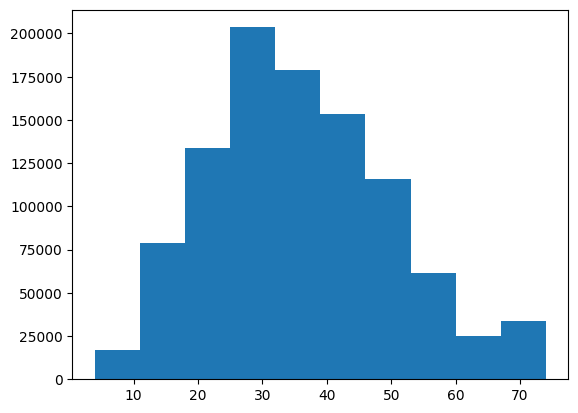

In [321]:
# find feature importance via Decision Tree regressor
A = X_busan[['longitude', 'latitude']].to_numpy()
B = df_subway_busan[['longitude', 'latitude']].to_numpy()

# Calculate the Manhattan distance between each element of A and B
manhattan_dist = np.abs(A[:, np.newaxis, :] - B).sum(axis=2)
in_range = manhattan_dist < RANGE
subway_cnt = np.sum(in_range, axis=1)

X_busan['subway_count_dist'] = subway_cnt

plt.hist(subway_cnt)

In [322]:
filter_subway(df_subway_busan)

In [323]:
df_subway_busan.head()

station_id  latitude  longitude address_by_law  city  line_1  line_2  \
0           1  0.666866  -0.793399   1114012000.0     1       1       0   
1           2  0.674251  -0.788660   1114016700.0     1       1       1   
2           3  0.677643  -0.782565   1111012600.0     1       1       0   
3           4  0.678688  -0.773865   1111015600.0     1       1       0   
4           5  0.678254  -0.763949   1111016300.0     1       1       0   

   line_3  line_4  line_5  line_6  line_7  line_8  line_9  line_AP  line_DL  \
0       0       1       0       0       0       0       0        1        0   
1       0       0       0       0       0       0       0        0        0   
2       0       0       0       0       0       0       0        0        0   
3       1       0       1       0       0       0       0        0        0   
4       0       0       0       0       0       0       0        0        0   

   line_KC  line_KJ  line_ND  line_US  
0        0        1        0        0  
1        0        0        0        0  
2        0        0        0        0  
3        0        0        0        0  
4        0        0        0        0

In [325]:
SUBWAY_LINE_BUSAN = ['line_1', 'line_2', 'line_3', 'line_4', 'line_5', 'line_6', 'line_7', 'line_8',
                    'line_AP', 'line_KJ', 'line_ND', 'line_KC', 'line_DL', 'line_US']

lines = df_subway_busan[SUBWAY_LINE_BUSAN].to_numpy()
distinct_line = np.count_nonzero(in_range @ lines, axis=1)

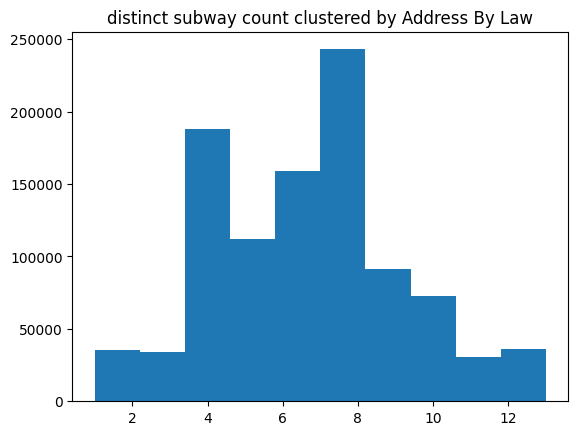

In [326]:
plt.hist(distinct_line)
plt.title("distinct subway count clustered by Address By Law")
plt.show()

In [327]:
has_line = distinct_line > 0

X_busan['distinct_line_dist'] = distinct_line
X_busan['has_subway_dist'] = has_line

In [328]:
df_school_busan = df_school[df_school['city'] == 1]

In [329]:
RANGE_SCHOOL = max(df_school_busan['latitude']) - min(df_school_busan['latitude']) + max(df_school_busan['longitude']) - min(df_school_busan['longitude'])
RANGE_SCHOOL = RANGE_SCHOOL * 0.01 # 1 / 100 of all school distance
RANGE_SCHOOL

0.005551658625172185

(array([ 54828., 156138., 185546., 233526., 153272., 114017.,  62209.,
         29873.,   9829.,   2134.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

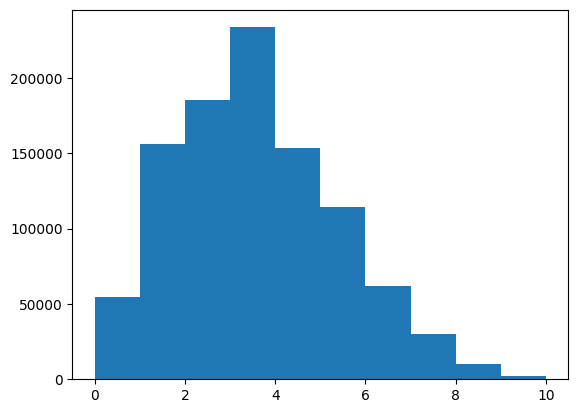

In [330]:
A = X_busan[['longitude', 'latitude']].to_numpy()
C = df_school_busan[['longitude', 'latitude']].to_numpy()

manhattan_dist_school = np.abs(A[:, np.newaxis, :] - C).sum(axis=2)
in_range_school = manhattan_dist_school < RANGE_SCHOOL
school_cnt = np.sum(in_range_school, axis=1)

X_busan['school_count_dist'] = school_cnt

plt.hist(school_cnt)

Cluster by address_by_law

In [331]:
# Step 1: Create a new DataFrame with unique addresses
df_school_busan_transform = pd.DataFrame(df_school_busan['address_by_law'].unique(), columns=['address_by_law'])

# Step 2: Perform the groupby operation and sum, then reset index to flatten the DataFrame
df_school_busan_counts = df_school_seoul['address_by_law'].value_counts()
df_school_busan_transform['number_of_school_addr'] = df_school_seoul_transform['address_by_law'].map(df_school_seoul_counts)


# Step 3: Compute the average of 'foundation_year' by 'address_by_law'
average_foundation_year = df_school_busan.groupby('address_by_law')['foundation_year'].mean().reset_index()
average_foundation_year.rename(columns={'foundation_year': 'average_foundation_year'}, inplace=True)

# Merge the summed columns and the averaged column into df_school_seoul_transform
df_school_busan_transform = df_school_busan_transform.merge(average_foundation_year, on='address_by_law', how='left')

# Now sch_df_transform contains the unique address_by_law, summed and averaged columns as specified.

In [332]:
df_school_busan_transform.head()

address_by_law  number_of_school_addr  average_foundation_year
0      1165010800                   11.0              1975.153846
1      1111016800                   15.0              1957.500000
2      1168010300                   15.0              1973.750000
3      1168010800                    5.0              1977.666667
4      1168010600                   10.0              1967.700000

In [333]:
df_subway_busan = df_subway[df_subway['city'] == 1]

# Step 1: Create a new DataFrame with unique addresses
df_subway_busan_transform = pd.DataFrame(df_subway_busan['address_by_law'].unique(), columns=['address_by_law'])

# Step 2: Perform the groupby operation and sum, then reset index to flatten the DataFrame
df_subway_busan_counts = df_subway_busan['address_by_law'].value_counts()
df_subway_busan_transform['number_of_subway_addr'] = df_subway_busan_transform['address_by_law'].map(df_subway_seoul_counts)
df_subway_busan_transform = df_subway_seoul_transform[df_subway_busan_transform['address_by_law'] != '-']
df_subway_busan_transform['address_by_law'] = pd.to_numeric(df_subway_busan_transform['address_by_law'])

In [336]:
#drop the column of previous method
drop_feature = ['cluster', 'subway_count', 'distinct_line', 'has_subway', 'school_count']
# X_seoul_second = X_seoul.drop(drop_feature, axis=1)
X_busan_second = X_busan.copy()
X_busan_second = pd.merge(X_busan_second, df_school_busan_transform, on='address_by_law', how='left')
X_busan_second = pd.merge(X_busan_second, df_subway_busan_transform, on='address_by_law', how='left')
X_busan_second = X_busan_second.fillna(0)

X_busan_second.head()

city  exclusive_use_area     floor  latitude  longitude  address_by_law  \
0     1           -1.144215 -0.574123  0.689431  -0.765620      1111017100   
1     1           -1.253499 -0.296118  0.689431  -0.765620      1111017100   
2     1           -0.884577 -0.296118  0.685361  -0.751986      1111017400   
3     1           -0.528870  0.120889  0.685221  -0.754190      1111017400   
4     1            0.969673 -0.435120  0.685221  -0.754190      1111017400   

   total_parking_capacity_in_site  total_household_count_in_sites  \
0                       -0.747549                       -0.926899   
1                       -0.747549                       -0.926899   
2                       -0.249759                       -0.528882   
3                       -0.249759                       -0.232807   
4                       -0.249759                       -0.232807   

   apartment_building_count_in_sites  tallest_building_in_sites  \
0                          -0.839598                        8.0   
1                          -0.839598                        8.0   
2                          -0.553712                       14.0   
3                          -0.410769                       15.0   
4                          -0.410769                       15.0   

   lowest_building_in_sites  supply_area  total_household_count_of_area_type  \
0                       4.0    -1.100212                           -0.763389   
1                       4.0    -1.228462                           -0.874574   
2                       9.0    -0.896645                           -0.284680   
3                      11.0    -0.444746                           -0.028338   
4                      11.0     0.778466                           -0.559552   

   room_count  bathroom_count  transaction_year  transaction_month  \
0   -2.919069       -1.154196              2006                  1   
1   -1.422105       -1.154196              2006                  1   
2   -1.422105       -1.154196              2006                  1   
3   -1.422105       -1.154196              2006                  1   
4    1.571822        0.813783              2006                  1   

   building_age  diff_height_in_site  excl_use_area_ratio  \
0     -0.773545            -0.464369            -0.950880   
1     -0.773545            -0.464369            -0.949617   
2      0.033850            -0.300707            -0.336646   
3     -0.081492            -0.464369            -0.618842   
4     -0.081492            -0.464369             1.117389   

   transaction_date_21~31  transaction_date_1~10  transaction_date_11~20  \
0                       0                      0                       1   
1                       0                      0                       1   
2                       0                      0                       1   
3                       0                      0                       1   
4                       0                      0                       1   

   front_door_structure_mixed  front_door_structure_-  \
0                           0                       0   
1                           0                       0   
2                           0                       0   
3                           0                       0   
4                           0                       0   

   front_door_structure_stairway  front_door_structure_corridor  \
0                              0                              1   
1                              0                              1   
2                              0                              1   
3                              0                              1   
4                              1                              0   

   heat_type_individual  heat_type_-  heat_type_district  heat_type_central  \
0                     1            0                   0                  0   
1                     1            0                   0                  0   
2      

In [337]:
X_train_busan, X_test_busan, y_train_busan, y_test_busan = train_test_split(
    X_busan_second, y_busan, test_size=0.3, random_state=2024)

In [338]:
# find feature importance via Decision Tree regressor
LOC_FEATURES = ['number_of_school_addr', 'number_of_subway_addr', 'distinct_line_dist', 'has_subway_dist', 'school_count_dist']
dt = DecisionTreeRegressor(random_state=2024)

predict_with_regressor(dt, 
                       X_train_busan[FLAT_FEATURES + LOC_FEATURES], 
                       X_test_busan[FLAT_FEATURES + LOC_FEATURES], 
                       y_train_busan, y_test_busan)


pd.DataFrame(data={
    'feature':dt.feature_names_in_, 
    'importance': dt.feature_importances_
}).sort_values(by='importance', ascending=False)

---------- DecisionTreeRegressor ----------
Rooted-MSE: 5.425e+07
MAE: 2.951e+07
Adjusted R-Squared: 0.9762



feature  importance
0               exclusive_use_area    0.479784
5                   address_by_law    0.303457
3                 transaction_year    0.080586
2   total_parking_capacity_in_site    0.047715
8               distinct_line_dist    0.039679
4        tallest_building_in_sites    0.029929
10               school_count_dist    0.009818
6            number_of_school_addr    0.009032
1                             city    0.000000
7            number_of_subway_addr    0.000000
9                  has_subway_dist    0.000000

## 5.1.1 Hyperparameters Tuning of Decision Tree 

In [35]:
dtr = DecisionTreeRegressor(random_state=2024)
dtr.fit(X_all, y_all)
print(regression_report(dtr.predict(X_all), y_all, 5))

Rooted-MSE: 3.631e+06
MAE: 4.666e+05
Adjusted R-Squared: 0.9999


In [36]:
X_5cols = X_all[top_5_cols]

dtr = DecisionTreeRegressor(random_state=2024)
dtr.fit(X_5cols, y_all)
print(regression_report(dtr.predict(X_5cols), y_all, 5))

Rooted-MSE: 3.71e+07
MAE: 2.018e+07
Adjusted R-Squared: 0.9866


In [37]:
dtr.get_depth()

47

## Optimal Depth

In [38]:
adjusted_r2_scores = []
for _ in range(1, 48):
    dtr = DecisionTreeRegressor(random_state=2024, max_depth=_)
    dtr.fit(X_5cols, y_all)
    y_pred = dtr.predict(X_5cols)
    # calculate adjusted r2 score
    n = y_all.shape[0]
    p = X_5cols.shape[1]
    r2 = r2_score(y_all, y_pred)
    adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
    adjusted_r2_scores.append(adj_r2)

In [39]:
threshold = 0.003
saturation_depth = 0
for i in range(1, len(adjusted_r2_scores)):
    diff = adjusted_r2_scores[i] - adjusted_r2_scores[i-1]
    if diff <= threshold:
        saturation_depth = i
        break
        
saturation_depth

26

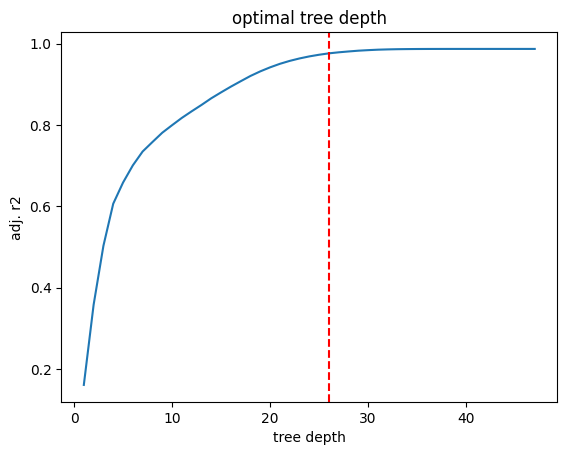

In [40]:
plt.plot(list(range(1,48)), adjusted_r2_scores)
plt.axvline(x=saturation_depth, color='red', linestyle='--')
plt.title("optimal tree depth")
plt.xlabel("tree depth")
plt.ylabel("adj. r2")
plt.show()

In [41]:
dtr = DecisionTreeRegressor(random_state=2024, max_depth=saturation_depth)
dtr.fit(X_5cols, y_all)
print(regression_report(dtr.predict(X_5cols), y_all, 5))

Rooted-MSE: 5.009e+07
MAE: 2.67e+07
Adjusted R-Squared: 0.9753


## 5.2 Decisino Tree Visualization

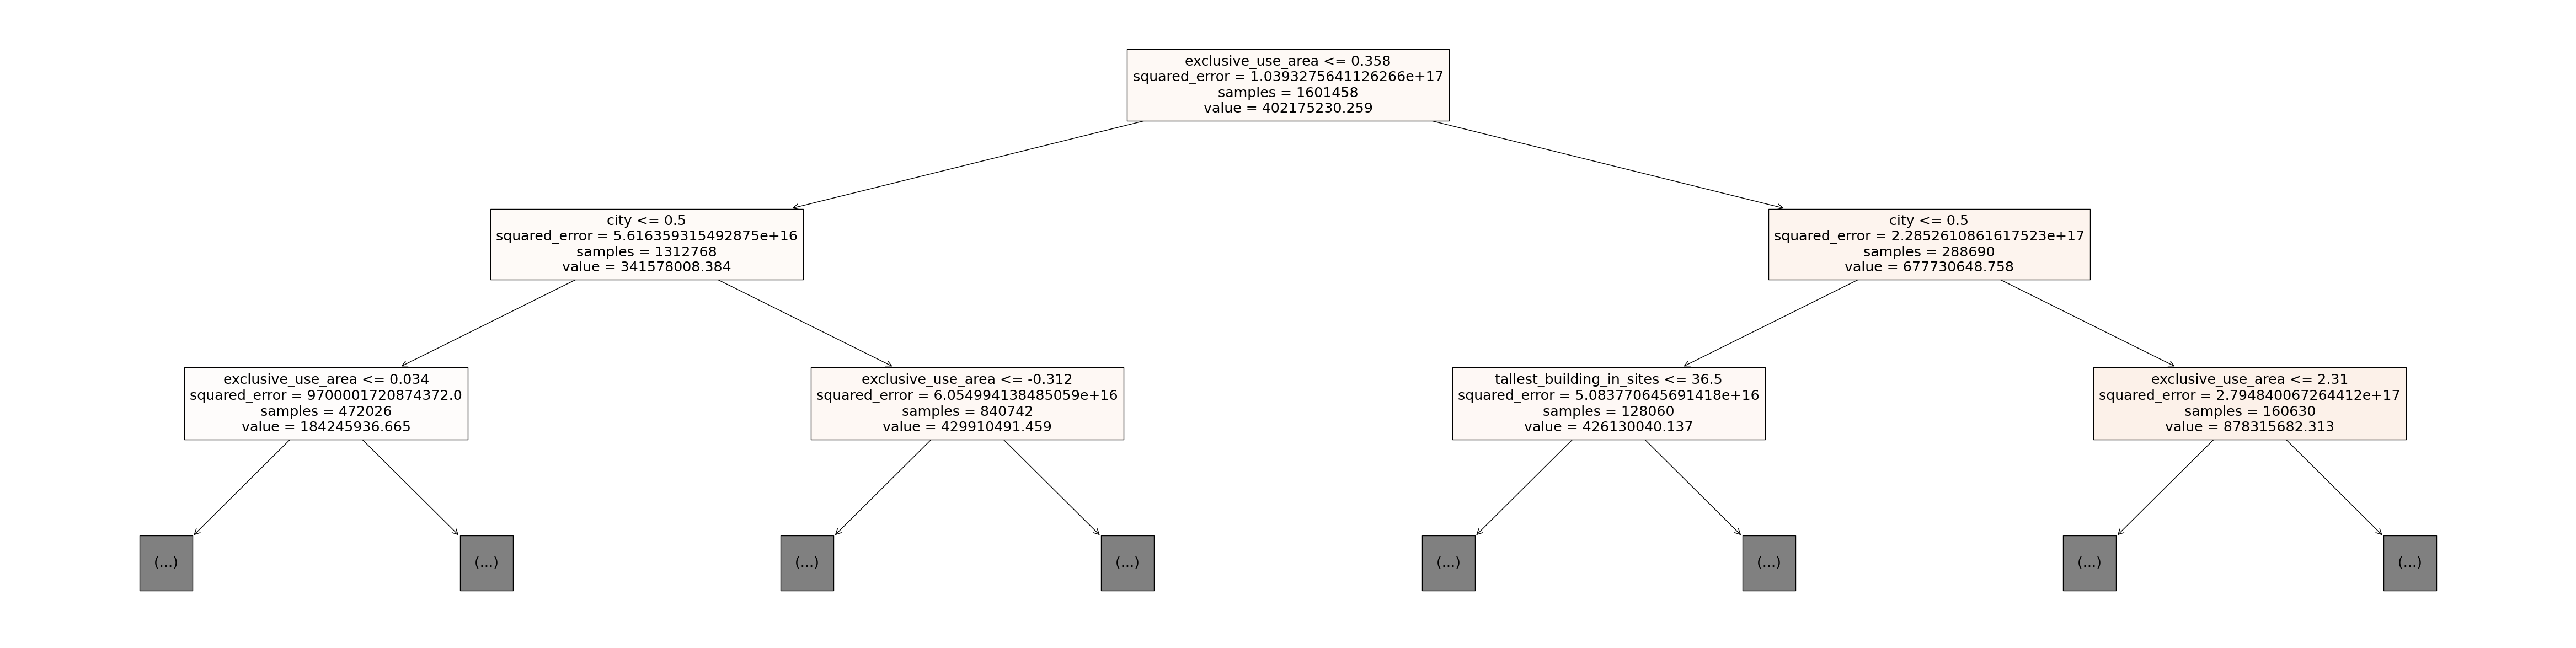

In [45]:
fig = plt.figure(figsize=(60, 15))
_ = plot_tree(dtr, feature_names=X_5cols.columns, filled=True, max_depth=2)

We can saw that the `excluse_use_area` and `city` directly determine the most of the first few splits.

In [46]:
feat_import_df = pd.DataFrame({'feature': dtr.feature_names_in_,
                               'importance': dtr.feature_importances_}) \
    .sort_values('importance', ascending=False)

feat_import_df.head()

feature  importance
0              exclusive_use_area    0.448271
1                            city    0.202022
2  total_parking_capacity_in_site    0.177429
4       tallest_building_in_sites    0.106945
3                transaction_year    0.065333